# Installation
Run this section to and download everything on the backend to make the notebook work first. If the requested version of arrayfire is unavailable via pip owing to age or things break for some other reason, flag me down!

In [ ]:
# tex installation for display of equations and fira for main text
%%shell
#apt-get install -y texlive texlive-latex-extra texlive-fonts-extra dvipng cm-super
wget https://github.com/bBoxType/FiraSans/archive/refs/heads/master.zip -O FiraSans.zip

unzip FiraSans.zip
sudo mkdir -p /usr/local/share/fonts/truetype/fira

find FiraSans-master/Fira_Sans_4_3/Fonts/Fira_Sans_TTF_4301 -type f -name "*.ttf" -exec sudo cp {} /usr/local/share/fonts/truetype/fira/ \;
sudo fc-cache -fv


--2024-05-11 19:55:08--  https://github.com/bBoxType/FiraSans/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/bBoxType/FiraSans/zip/refs/heads/master [following]
--2024-05-11 19:55:08--  https://codeload.github.com/bBoxType/FiraSans/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘FiraSans.zip’

FiraSans.zip            [ <=>                ]  98.96M  20.4MB/s    in 7.2s    

2024-05-11 19:55:16 (13.7 MB/s) - ‘FiraSans.zip’ saved [103767496]

Archive:  FiraSans.zip
f54eeb3124c63fe9b5bcd36d09d1cd46788cd15e
   creating: FiraSans-master/
   creating: FiraSans-master/Fira_Code_3_2

In [ ]:
# External Packages (pip main scripts)
!pip install arrayfire==3.8.0+cu112 -f https://repo.arrayfire.com/python/wheels/3.8.0/
!pip install brian2hears
!pip install brian2
!pip install importlib
!pip install sklearn

Looking in links: https://repo.arrayfire.com/python/wheels/3.8.0/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.5/868.5 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 19.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.8 MB/s eta 0:00:00
  Created wheel for brian2hears: filename=brian2hears-0.9.2-py3-none-any.whl size=78209 sha256=6ebb4102eb983d07f6bcbf45a5903bcd39140bb71fef96adb788184af4c7ba84
  Stored in directory: /root/.cache/pip/wheels/bf/75/0e/afbdbb140fdbc87ea5105260eac89d9cc0493039fcf8b00418
Successfully built brian2hears
  Preparing metadata (setup.py) ... done
  Created wheel for importlib: filename=importlib-1.0.4-py3-none-any.whl size=5852 sha256=aad5aa575ce3333d495064d44f50b5d0e854e81e7d273a5ab5c0fff4c40f2c58
  Stored in directory: /root/.cache/pip/wheels/0f/77/67/b2657372b2523148d81dcdd

# Class Injections / Imports
The scripts below all manually insert some overrides to existing libraries via perl and then python's regex (b/c it can be difficult to work with too many recursions/operands in perl without tripping over yourself). Chiefly, binds a parent class to return a new passable argument (plus some new methods) so that the gammatone filterbank can output bands separately for each frequency range passed - ensuring that the new arguments are accessible at all levels of the class hierarchy. Note that if you want to just hear what something sounds like in total once it passes through a filterbank (not on a cillia-by-cillia basis), you can just set the new argument, "use_individual_outputs" to false - and call the approxgammatone function and the generate method in isolation (not within the current defs, since that will break everything). You might adopt a similar method in the future to hijack other filterbanks and models - but this will require some fine-tuning of the regexprs - but is definitely doable and integrateable, if you're so willing.

In [ ]:
%%shell
#!/bin/bash

file_path="/usr/local/lib/python3.10/dist-packages/brian2hears/filtering/filterbanklibrary.py"
cp "$file_path" "${file_path}.bak" # Now we don't need this because it works
perl -i -0pe '
    s/(class ApproximateGammatone\(LinearFilterbank\)(?:.*?\n)*?)(\s*def __init__\(self,)/$1    def get_individual_filter_outputs(self, input_signal):\n        filter_outputs = []  # List to store the outputs of each filter for each bandwidth\n        for i in range(len(self.cf)):\n            bandwidth_filter_outputs = []  # List to store the outputs of each filter for the current bandwidth\n            for j in range(self.order):\n                # Apply the j-th filter for the i-th bandwidth to the input signal\n                output = self.filters[i * self.order + j].apply(input_signal)\n                bandwidth_filter_outputs.append(output)  # Append the output to the list of filter outputs\n            filter_outputs.append(bandwidth_filter_outputs)  # Append the outputs for the current bandwidth to the main list\n        return filter_outputs\n$2/s' "$file_path"

In [ ]:
%%shell
#!/bin/bash

file_path="/usr/local/lib/python3.10/dist-packages/brian2hears/filtering/filterbanklibrary.py"
cp "$file_path" "${file_path}.bak" # Now we don't need this because it works
perl -i -0pe '
    $process_method_code = qq{
        def process(self, func=None, duration=None, buffersize=32):
            if self.use_individual_outputs:
                if duration is None:
                    duration = self.duration
                if not isinstance(duration, int):
                    duration = int(duration * self.samplerate)

                self.buffer_init()
                total_output = []
                for start in range(0, duration, buffersize):
                    end = min(start + buffersize, duration)
                    input_signal = self.source.buffer_fetch(start, end)
                    output = self.get_individual_filter_outputs(input_signal)
                    total_output.append(output)
                return np.concatenate(total_output, axis=0)
            else:
                return super().process(func, duration, buffersize)
    };

    if (/class ApproximateGammatone\(LinearFilterbank\)/) {
        unless (/def process\(self, func=None, duration=None, buffersize=32\):/) {
            s/(def get_individual_filter_outputs\(self, input_signal\):.*?return filter_outputs\n)/$1\n$process_method_code/s;
        }
    }
' "$file_path"

In [ ]:
import re
import os

def modify_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    new_init_code = """
    def __init__(self, source, cf, bandwidth, order=4, use_individual_outputs=False):
        self.cf = cf
        cf = np.asarray(np.atleast_1d(cf))
        bandwidth = np.asarray(np.atleast_1d(bandwidth))
        self.samplerate = source.samplerate
        dt = float(1 / self.samplerate)
        phi = 2 * np.pi * bandwidth * dt
        theta = 2 * np.pi * cf * dt
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        alpha = -np.exp(-phi) * cos_theta
        b0 = np.ones(len(cf))
        b1 = 2 * alpha
        b2 = np.exp(-2 * phi)
        z1 = (1 + alpha * cos_theta) - (alpha * sin_theta) * 1j
        z2 = (1 + b1 * cos_theta) - (b1 * sin_theta) * 1j
        z3 = (b2 * np.cos(2 * theta)) - (b2 * np.sin(2 * theta)) * 1j
        tf = (z2 + z3) / z1
        a0 = abs(tf)
        a1 = alpha * a0
        self.filt_a = np.dstack((np.array([b0, b1, b2]).T,)*order)
        self.filt_b = np.dstack((np.array([a0, a1, np.zeros(len(cf))]).T,)*order)
        super().__init__(source, self.filt_b, self.filt_a)
    """.strip()

    pattern = re.compile(r'(def __init__\(self, source, cf,  bandwidth,order=4\):)(.*?)(?=\n\w)', re.DOTALL)
    content = re.sub(pattern, new_init_code, content)
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(content)

modify_file('/usr/local/lib/python3.10/dist-packages/brian2hears/filtering/filterbanklibrary.py')


In [ ]:
# Globals + imports - streamline this later
import numpy as np
import time
from types import NoneType
from brian2 import *
from brian2hears import *
import scipy.signal
from wave import Wave_read
import importlib
import scipy.io
import soundfile as sf
import librosa
import tensorflow as tf
from tqdm import tqdm
import subprocess
import pprint
import tarfile
import gc
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.animation import FuncAnimation
from matplotlib.colors import to_rgba
import matplotlib.font_manager as fm
from itertools import cycle
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from datetime import datetime
import os
import pickle
import gzip
import tempfile
import shutil
import random
import arrayfire as af
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import Input, Conv1D, Conv1DTranspose, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import json
import torch
import torch.optim as optim
import torch.nn as nn
import math

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available:
  print('GPU found')

font_dirs = ["/usr/local/share/fonts/truetype"]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)

font_check = fm.get_font_names()
print(f"matplotlibfonts: {font_check}")

plt.rcParams['font.family'] = 'Fira Sans'
plt.rcParams['savefig.transparent'] = True

af.set_backend("cuda")
importlib.reload(filterbanklibrary)

GPU found
matplotlibfonts: ['STIXSizeFourSym', 'Liberation Mono', 'STIXSizeFiveSym', 'cmss10', 'STIXSizeThreeSym', 'cmb10', 'STIXNonUnicode', 'Liberation Sans', 'Liberation Serif', 'Fira Sans Condensed', 'DejaVu Sans Mono', 'cmmi10', 'DejaVu Serif Display', 'STIXSizeOneSym', 'DejaVu Sans Display', 'Liberation Sans Narrow', 'cmex10', 'Humor Sans', 'Fira Sans', 'DejaVu Sans', 'STIXSizeTwoSym', 'STIXGeneral', 'Fira Sans Compressed', 'cmr10', 'cmsy10', 'DejaVu Serif', 'cmtt10']


<module 'brian2hears.filtering.filterbanklibrary' from '/usr/local/lib/python3.10/dist-packages/brian2hears/filtering/filterbanklibrary.py'>

# Functions and Helpers (Backend)
All the functions and stuff used by the frontend, to be initialized in advance.
Declarations only - process moved to the experimental protocol section.

In [ ]:
from typing import Union, List, Tuple, Dict, Any
ArrayContainer = Union[List[Any], Tuple[Any, ...]]

def extract_data_arrays(
    sampled_data: Dict[str, Dict[str, Dict[str, ArrayContainer]]],
    file_id: str = None,
    processing_type: str = 'original',
    component_type: str = 'real'
) -> np.ndarray:
    """
    Extracts arrays from the sampled data structure.

    Parameters:
    - sampled_data (dict): The data structure containing sampled data.
    - file_id (str): Specific file ID to extract data from. If None, data from all files will be extracted.
    - processing_type (str): Type of processing ('original' or 'lossy').
    - component_type (str): Type of component ('real' or 'imaginary').

    Returns:
    - np.ndarray: An array of extracted data arrays.
    """
    data_arrays = []

    def extract_from_container(container: ArrayContainer) -> List[np.ndarray]:
        """Extracts arrays from a list, tuple, or dict."""
        if isinstance(container, (list, tuple)):
            return [data for data in container]
        elif isinstance(container, dict):
            return [data for key, data in container.items()]
        else:
            print(f"Expected a list, tuple, or dict but got {type(container)}")
            return []

    def fetch_data_for_file(fid: str) -> List[np.ndarray]:
        """Fetch data arrays for a given file ID."""
        if fid in sampled_data:
            file_data = sampled_data[fid]
            if processing_type in file_data:
                process_data = file_data[processing_type]
                if component_type in process_data:
                    bins = process_data[component_type]
                    return extract_from_container(bins)
                else:
                    print(f"Component type '{component_type}' not found for file ID '{fid}'.")
            else:
                print(f"Processing type '{processing_type}' not found for file ID '{fid}'.")
        else:
            print(f"File ID '{fid}' not found in data.")
        return []

    if file_id:
        # Fetch data for a specific file ID
        data_arrays.extend(fetch_data_for_file(file_id))
    else:
        # Fetch data for all file IDs
        for fid in sampled_data.keys():
            data_arrays.extend(fetch_data_for_file(fid))

    if not data_arrays:
        print(f"No data arrays were extracted for '{processing_type}' and '{component_type}'. Check your input data.")

    return np.array(data_arrays)


In [ ]:
def preview_separate(filter_outputs):
    """
    Writes a dictionary for all of the separate filter outputs in the training data - for previews and exports of the filtering process.
    Args:
    filter_outputs: The list object, containing numpy arrays of (fft_size, frequency_bins).
    Returns:
    dict: A dictionary of 2D numpy arrays, where each key corresponds to the audio heard by a given cochlear cilia.
    """
    num_frames, num_frequency_bins = filter_outputs[0].shape
    separated_previews = {f"frequencybin_{i}": [] for i in range(num_frequency_bins)}
    for array in filter_outputs:
        for i in range(num_frequency_bins):
            separated_previews[f"frequencybin_{i}"].append(array[:, i])
    for key in separated_previews:
        separated_previews[key] = np.concatenate(separated_previews[key])
    return separated_previews

In [ ]:
def colab_write_frequency_bins_to_wav_and_archive(filter_outputs, file_path, sample_rate):
    """
    Exports each filter's waveform by concatenating arrays along the time domain across bins.
    Assumes filter_outputs is a dictionary with nested dictionaries where each bin contains a 2D numpy array of shape (fft_size, num_filters).

    Args:
        filter_outputs: dictionary containing 'original' key, which has dictionaries of bins each holding numpy arrays.
        file_path: path to the base filename for exporting
        sample_rate: sample rate for exported wav files
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    directory = f"{os.path.splitext(file_path)[0]}_iirexport_{timestamp}"
    os.makedirs(directory, exist_ok=True)

    if 'original' in filter_outputs and isinstance(filter_outputs['original'], dict):
        nested_dict = filter_outputs['original']
        num_filters = None
        concatenated_frames = {}
        for bin_key, waveform in nested_dict.items():
            if isinstance(waveform, np.ndarray):
                if num_filters is None:
                    num_filters = waveform.shape[1]
                    concatenated_frames = {f"filter_{i}": [] for i in range(num_filters)}
                for i in range(num_filters):
                    concatenated_frames[f"filter_{i}"].append(waveform[:, i])
        for filter_index in range(num_filters):
            concatenated_waveform = np.concatenate(concatenated_frames[f"filter_{filter_index}"])
            filename = f"{directory}/filter_{filter_index+1:03d}_{timestamp}.wav"
            sf.write(filename, concatenated_waveform, sample_rate)
            print(f"Written WAV file for filter {filter_index+1:03d}")
    else:
        print("Expected 'original' key with a dictionary of numpy arrays. Structure not found.")
    tarball_name = f"{directory}.tar.gz"
    os.system(f"tar -czf '{tarball_name}' -C '{directory}' .")
    print(f"Tarball created: {tarball_name}")
    os.system(f"rm -r '{directory}'")


In [ ]:
## FFMPEG SUBPROCESSES
def convert_to_mp3_and_back(input_wav_path, output_wav_path, bitrate='64k', file_sr=44100):
    temp_mp3 = tempfile.NamedTemporaryFile(suffix='.mp3', delete=False)
    command_mp3 = [
        'ffmpeg', '-y',
        '-i', input_wav_path,
        '-codec:a', 'libmp3lame',
        '-b:a', bitrate,
        temp_mp3.name
    ]
    subprocess.run(command_mp3, check=True)

    command_wav = [
        'ffmpeg', '-y',
        '-i', temp_mp3.name,
        '-acodec', 'pcm_s16le',
        '-ar', str(file_sr),
        output_wav_path
    ]

    subprocess.run(command_wav, check=True)
    temp_mp3.close()

def prepare_audio_files(file_path, duration, UseDualMono=True):
    """
    Converts an audio file to a standard PCM format readable by Python's wave module, handling stereo files by either converting them into
    two separate mono files (left and right channels) or one randomly chosen channel, depending on the UseDualMono parameter. Mono files are simply converted.
    """
    try:
        probe_command = ['ffprobe', '-v', 'error', '-select_streams', 'a:0', '-show_entries', 'stream=channels', '-of', 'default=noprint_wrappers=1:nokey=1', file_path]
        probe_result = subprocess.run(probe_command, text=True, capture_output=True)
        if probe_result.returncode != 0:
            print("Error probing the file:", probe_result.stderr)
            return []
        channels = int(probe_result.stdout.strip())
        print(f"Detected {channels} channels.")
        base_name = os.path.splitext(file_path)[0]
        temp_files = []
        if channels == 2:
            if UseDualMono:
                channel_labels = ['_L', '_R']
            else:
                channel_labels = [random.choice(['_L', '_R'])]

            for i, label in enumerate(channel_labels):
                output_file = f"{base_name}{label}.wav"
                command = [
                    'ffmpeg', '-y', '-i', file_path,
                    '-map_channel', f'0.0.{0 if label == "_L" else 1}',
                    '-acodec', 'pcm_s16le',
                    '-ar', '44100',
                    '-ac', '1',
                    '-t', str(duration),
                    output_file
                ]
                print("Running command:", ' '.join(command))
                subprocess_result = subprocess.run(command, text=True, capture_output=True)
                if subprocess_result.returncode != 0:
                    print("ffmpeg error:", subprocess_result.stderr)
                    continue
                temp_files.append(output_file)

        elif channels == 1:  # Mono file, standardize format and return
            output_file = f"{base_name}_mono.wav"
            command = [
                'ffmpeg', '-y', '-i', file_path,
                '-acodec', 'pcm_s16le',
                '-ar', '44100',
                '-ac', '1',
                '-t', str(duration),
                output_file
            ]
            subprocess_result = subprocess.run(command, text=True, capture_output=True)
            if subprocess_result.returncode == 0:
                temp_files.append(output_file)
        return temp_files
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return []


In [ ]:
def cochlear_iir(file_path, fft_size=256, downloadfile=False, rectify=True, min_frequency=20, max_frequency=20000, num_frequency_bins=100, bw=None, random_order=False, with_lossy_backprop=False, *args, **kwargs):
    y, file_sr = librosa.load(file_path, sr=None, )
    brainload = loadsound(f"{file_path}")  # Ensure load is capable of reading from file path
    num_frames_original = int(np.ceil(len(y) / fft_size))
    total_frames = num_frames_original * (2 if with_lossy_backprop else 1)
    print(f"now passing file: {file_path} through filterbank...")
    filter_meter = tqdm(total=total_frames, desc='filters/s', unit='filters', leave=True, position=0)
    global center_frequencies
    center_frequencies = erbspace(min_frequency*Hz, max_frequency*Hz, num_frequency_bins)
    if rectify:
              brainload = FunctionFilterbank(brainload, lambda x: clip(x, 0, Inf)**(1.0/3.0))
    if bw is None:
        bw = 10**(0.037 + 0.785 * np.log10(center_frequencies / Hz))
    def process_audio(audio_data, audio_brain, num_frames, file_sr):
        filter_outputs = {}
        try:
            gammatone = ApproximateGammatone(audio_brain, center_frequencies, bw, 4, use_individual_outputs=True)
            framefilter = gammatone.process(buffersize=fft_size)
            for i in range(num_frames):
                start_sample = i * fft_size
                end_sample = min(start_sample + fft_size, framefilter.shape[0])
                frame = framefilter[start_sample:end_sample]
                if len(frame) < fft_size:  # zero-pad if necessary
                    frame = np.pad(frame, ((0, fft_size - len(frame)), (0, 0)), mode='constant')
                filter_outputs[f'bin_{i}'] = frame
                filter_meter.update(1)
        except Exception as e:
            print("Error during processing:", e)
        print(f'Type of filter_outputs: {type(filter_outputs)}') #dictionary
        return filter_outputs
    results = {'original': process_audio(y, brainload, num_frames_original, file_sr)}

    if downloadfile:
        colab_write_frequency_bins_to_wav_and_archive(results, file_path, file_sr)

    if with_lossy_backprop:
        temp_wav_path = file_path.replace('.wav', '_temp.wav')
        output_wav_path = file_path.replace('.wav', '_back_from_mp3.wav')
        convert_to_mp3_and_back(file_path, output_wav_path, bitrate='64k', file_sr=file_sr)
        y_lossy, _ = librosa.load(output_wav_path, sr=file_sr)
        brianload = loadsound(f"{output_wav_path}")
        results['lossy'] = process_audio(y_lossy, brainload, num_frames_original, file_sr)
        os.remove(output_wav_path)  # Clean up

    filter_meter.close()
    return results

In [ ]:
def epochset(file_paths, *args, **kwargs):
    results = {}
    filename_mapping = {}
    new_file_paths = []
    with_lossy_backprop = kwargs.get('with_lossy_backprop', False)
    backend = kwargs.get('backend', "pytorch")
    duration = kwargs.get('duration', 60)
    UseDualMono = kwargs.get('UseDualMono', True)
    for file_path in file_paths:
        temp_files = prepare_audio_files(file_path, duration, UseDualMono)
        if not temp_files:
            continue
        new_file_path = temp_files[0]  # Assume the first file is what we need
        new_file_paths.append(new_file_path)
        normalized_name = normalize_filename(new_file_path)
        filename_mapping[file_path] = normalized_name
        outputs = cochlear_iir(new_file_path, *args, **kwargs)
        for processing_type in outputs:
            key = f"{processing_type}_{normalized_name}"
            print(f"now performing discrete fourier transform series for key: {normalized_name}...")
            print(f"performing calculations on {processing_type} version of the original file...")
            results[key] = perform_dft(outputs[processing_type], **kwargs)

    return results, filename_mapping, new_file_paths, outputs  # we return the filtered outputs

In [ ]:
def perform_dft(named_arrays, with_lossy_backprop=False, progress_meter=None, backend='pytorch', **kwargs):
    if isinstance(named_arrays, list):
        named_arrays = {f'bin_{i}': named_arrays[i] for i in range(len(named_arrays))}

    if progress_meter is None:
        total_length = sum(len(data) for data in named_arrays.values())
        progress_meter = tqdm(total=total_length, desc='DFTs per second', unit='DFTs', leave=True, position=0)

    dfts_for_network = {'real': {}, 'imaginary': {}}

    def get_target_length(frames):
        return max(len(frame) for frame in frames)

    def pad_or_trim_frame(frame, target_length):
        if len(frame) > target_length:
            return frame[:target_length]
        else:
            padding = target_length - len(frame)
            if isinstance(frame, torch.Tensor):
                return torch.cat((frame, torch.zeros(padding, dtype=frame.dtype, device=frame.device)), dim=0)
            else:
                return np.pad(frame, (0, padding), 'constant')

    def process_with_pytorch(frames, use_gpu):
        target_length = get_target_length(frames)
        if use_gpu:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            device = torch.device('cpu')

        # Convert and pad frames before batch processing
        padded_frames = [pad_or_trim_frame(torch.tensor(frame, dtype=torch.complex64, device=device), target_length) for frame in frames]
        stacked_frames = torch.stack(padded_frames)

        # Perform FFT on all frames at once
        dft_results = torch.fft.fft(stacked_frames)
        real_parts = torch.real(dft_results).cpu().numpy()  # Ensure transfer back to CPU for compatibility with numpy
        imaginary_parts = torch.imag(dft_results).cpu().numpy()

        progress_meter.update(len(frames))
        return real_parts, imaginary_parts

    def process_with_arrayfire(frames):
        real_parts = []
        imaginary_parts = []
        target_length = get_target_length(frames)
        frames = np.array(frames) if not isinstance(frames, np.ndarray) else frames
        for frame in frames:
            frame = pad_or_trim_frame(frame, target_length)
            af_array = af.interop.from_ndarray(frame)
            dft_result = af.dft(af_array)
            real_parts.append(np.real(dft_result.to_ndarray()))
            imaginary_parts.append(np.imag(dft_result.to_ndarray()))
            progress_meter.update(1)
        return np.stack(real_parts), np.stack(imaginary_parts)

    def process_with_tensorflow(frames):
        real_parts = []
        imaginary_parts = []
        target_length = get_target_length(frames)
        frames = np.array(frames) if not isinstance(frames, np.ndarray) else frames
        for frame in frames:
            frame = pad_or_trim_frame(frame, target_length)
            frame_tensor = tf.convert_to_tensor(frame, dtype=tf.complex64)
            dft_result = tf.signal.fft(frame_tensor)
            real_parts.append(tf.math.real(dft_result).numpy())
            imaginary_parts.append(tf.math.imag(dft_result).numpy())
            progress_meter.update(1)
        return np.stack(real_parts), np.stack(imaginary_parts)

    for key, frames in named_arrays.items():
        if backend == 'pytorch':
            use_gpu = kwargs.get('use_gpu', "False")
            real_parts, imaginary_parts = process_with_pytorch(frames, use_gpu=use_gpu)
        elif backend == 'tensorflow':
            real_parts, imaginary_parts = process_with_tensorflow(frames)
        elif backend == 'pytorch':
            real_parts, imaginary_parts = process_with_pytorch(frames)
        else:
            raise ValueError(f"Unsupported backend: {backend}")
        dfts_for_network['real'][key] = real_parts
        dfts_for_network['imaginary'][key] = imaginary_parts

    progress_meter.close()

    if backend == 'tensorflow':
        tf.keras.backend.clear_session()
        gc.collect()

    if backend == 'pytorch' and use_gpu:
        torch.cuda.empty_cache()  # Clear GPU cache after processing

    return dfts_for_network


In [ ]:
def configure_epochs(file_paths, num_bins=None, fft_size=256, ignore_temporality=False, *args, **kwargs):
    full_results, filename_mapping, new_file_paths, outputs = epochset(file_paths, fft_size=fft_size, *args, **kwargs)
    epoch_data = {}

    for file_path, normalized_name in filename_mapping.items():
        for key in [f"original_{normalized_name}", f"lossy_{normalized_name}"]:
            if key in full_results:
                dfts = full_results[key]
                if normalized_name not in epoch_data:
                    epoch_data[normalized_name] = {}
                if 'original' in key:
                    processing_type = 'original'
                else:
                    processing_type = 'lossy'

                epoch_data[normalized_name][processing_type] = {'real': {}, 'imaginary': {}}
                for component_type in ['real', 'imaginary']:
                    if component_type in dfts:
                        bin_limit = num_bins.get(normalized_name, None) if num_bins else None
                        for bin_key, values in dfts[component_type].items():
                            if 'bin' in bin_key:
                                bin_index = int(bin_key.split('_')[-1])
                                if bin_limit is None or bin_index < bin_limit:
                                    epoch_data[normalized_name][processing_type][component_type][bin_key] = values

    if ignore_temporality:
        for basename in epoch_data:
            for processing_type in epoch_data[basename]:
                for component_type in ['real', 'imaginary']:
                    bin_keys = list(epoch_data[basename][processing_type][component_type].keys())
                    random.shuffle(bin_keys)
                    shuffled_bins = {key: epoch_data[basename][processing_type][component_type][key] for key in bin_keys}
                    epoch_data[basename][processing_type][component_type] = shuffled_bins

    return epoch_data, outputs

In [ ]:
## Diagnostics and stuff ---> just for helping me build/debug (and for you to use too)
def print_first_four_bins(sampled_data):
    for file_id, processing_types in sampled_data.items():
        print(f"File ID: {file_id}")
        for processing_type, components in processing_types.items():
            print(f"  Processing Type: {processing_type}")
            for component_type, bins in components.items():
                print(f"    Component Type: {component_type}")
                bin_keys = list(bins.keys())[:4]
                for bin_key in bin_keys:
                    data = bins[bin_key]
                    print(f"      {bin_key}: Data Shape {data.shape if hasattr(data, 'shape') else 'not available'}")
                if not bin_keys:
                    print("      No bins available")
        print("\n")

def print_keys(d, indent=0):
    """Recursively prints the keys of nested dictionaries, skipping any keys that directly contain numpy arrays."""
    for key, value in d.items():
        if isinstance(value, np.ndarray):
            continue
        print('  ' * indent + str(key))
        if isinstance(value, dict):
            print_keys(value, indent + 1)

def count_total_arrays(data_dict):
    """Count all numpy arrays inside the lists of each dictionary entry."""
    total_arrays = 0
    for arrays in data_dict.values():
        total_arrays += len(arrays)
    return total_arrays

def nab_fileids(sampled_data):
    filearr = []
    for file_id, processing_types in sampled_data.items():
        filearr.append(file_id)
    return filearr

def save_svg(fig, filename):
    """Save a matplotlib figure as SVG."""
    output_dir = './animated_svgs'
    os.makedirs(output_dir, exist_ok=True)
    fig.savefig(os.path.join(output_dir, f'{filename}.svg'), format='svg')

def normalize_filename(file_path):
    base_name = os.path.splitext(os.path.basename(file_path))[0]
    normalized_name = base_name.replace(' ', '_').replace('-', '_').lower()
    return normalized_name

def run_iostat():
    # This function will run `iostat` command every second and print its output
    try:
        # The '-x 1' option tells iostat to provide extended statistics every 1 second
        process = subprocess.Popen(['iostat', '-dx', '1'], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        while True:
            output = process.stdout.readline()
            if output == '' and process.poll() is not None:
                break
            if output:
                print(output.strip())
    except Exception as e:
        print(f"Error running iostat: {e}")


In [ ]:
## custom wrapper for gpu-accelerated Kamada-Kawai
class KamadaKawaiOptimizer(nn.Module):
    def __init__(self, D, K):
        super(KamadaKawaiOptimizer, self).__init__()
        self.D = D
        self.K = K
        self.pos = nn.Parameter(torch.rand(D.shape[0], 2))

    def forward(self):
        dist = torch.cdist(self.pos, self.pos, p=2)
        delta = self.D - dist
        energy = 0.5 * torch.sum(self.K * delta**2)
        return energy

def compute_kamada_kawai_positions(D, K, num_epochs=1000, learning_rate=0.01):
    model = KamadaKawaiOptimizer(D, K)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss = model()
        loss.backward()
        optimizer.step()

    return model.pos.detach().numpy()

def initialize_kamada_kawai_layout(G, num_epochs=1000, learning_rate=0.01):
    num_nodes = G.number_of_nodes()
    D = np.zeros((num_nodes, num_nodes))
    K = np.zeros((num_nodes, num_nodes))

    lengths = dict(nx.all_pairs_dijkstra_path_length(G))

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                D[i, j] = lengths[i][j]
                K[i, j] = 1 / D[i, j]**2

    D = torch.tensor(D, dtype=torch.float32)
    K = torch.tensor(K, dtype=torch.float32)

    return compute_kamada_kawai_positions(D, K, num_epochs=num_epochs, learning_rate=learning_rate)


In [ ]:
### STOCHASTIC PROCESSES
### plot sample bins
def plot_indices(indices, total_bins, method_name, file_id_colors=None, file_ids_at_indices=None):
    """Plot the indices as a time series to visualize the selection sequence and color them by file_id."""
    print("Indices length:", len(indices))
    print("File IDs at Indices length:", len(file_ids_at_indices))
    print("Sample indices values:", indices[:10])
    print("Sample file IDs at indices values:", file_ids_at_indices[:10])

    label_step = max(1, total_bins // 30)
    label_size = min(10, max(5, 500 // total_bins))
    indices = np.clip(indices, 0, total_bins - 1)

    plt.figure(figsize=(20, 6))
    if file_id_colors and file_ids_at_indices:
        colors = [file_id_colors.get(file_id, 'grey') for file_id in file_ids_at_indices]
    else:
        colors = ['blue'] * len(indices)
    colors = colors[:len(indices)]
    unique_colors = set(colors)
    color_labels = {color: file_id for file_id, color in file_id_colors.items() if color in unique_colors}
    for color, label in color_labels.items():
        specific_indices = [i for i, c in enumerate(colors) if c == color]
        specific_indices = np.clip(specific_indices, 0, len(indices) - 1)
        specific_values = [indices[i] for i in specific_indices]
        plt.scatter(specific_indices, specific_values, color=color, label=label)
    plt.plot(indices, 'grey', label='sampling sequence', alpha=0.4)  # Using grey to keep focus on points
    bin_labels = [str(i) if i % label_step == 0 else '' for i in range(total_bins)]
    plt.yticks(np.arange(0, total_bins, label_step), bin_labels[::label_step], fontsize=label_size)
    plt.xlabel('Sample Step')
    plt.ylabel('Bin ID')
    plt.title(f'Bin Sampling Sequence for {method_name}')
    plt.legend(title="File IDs")
    plt.grid(True)
    plt.show()

### A Rössler system / animation stuff
def rossler_attractor(start, num_samples, a, b, c, dt=0.01):
    x, y, z = start
    path_x = [x]
    path_y = [y]
    path_z = [z]
    for _ in range(num_samples - 1):
        dx = -y - z
        dy = x + a * y
        dz = b + z * (x - c)
        x += dx * dt
        y += dy * dt
        z += dz * dt
        path_x.append(x)
        path_y.append(y)
        path_z.append(z)
    return np.array([path_x, path_y, path_z]).T

def animate_rossler(process_path):
    """Animate the Rössler attractor."""
    %matplotlib inline
    x, y, z = process_path.T
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    line_z, = ax.plot([], [], [], lw=2, label='Z-component', color='red')
    line_x, = ax.plot([], [], [], lw=1, label='X-component', color='blue', alpha=0.5)
    line_y, = ax.plot([], [], [], lw=1, label='Y-component', color='green', alpha=0.5)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', borderaxespad=0.7, shadow=True)
    text = ax.text2D(0.05, 0.95, "X, Y, and Z Components of the Rössler system", transform=ax.transAxes, fontsize='small')

    def init():
        ax.set_xlim([min(x), max(x)])
        ax.set_ylim([min(y), max(y)])
        ax.set_zlim([min(z), max(z)])
        ax.set_xlabel('X-axis', fontsize='x-small')
        ax.set_ylabel('Y-axis', fontsize='x-small')
        ax.set_zlabel('Z-axis', fontsize='x-small')
        return line_z, line_x, line_y, text

    def animate(i):
        line_z.set_data(x[:i], y[:i])
        line_z.set_3d_properties(z[:i])
        line_x.set_data(x[:i], [0] * i)
        line_x.set_3d_properties(z[:i])
        line_y.set_data([0] * i, y[:i])
        line_y.set_3d_properties(z[:i])
        ax.view_init(elev=10, azim=i * 60 / len(x))
        return line_z, line_x, line_y, text
    rosslerspace = FuncAnimation(fig, animate, init_func=init, frames=len(x), interval=50, blit=True)
    html_video = HTML(rosslerspace.to_html5_video())
    display(html_video)

    return html_video

### Maximal Entropy Random Walk + Animators
def maximal_entropy_random_walk(G, num_steps):
    A = nx.adjacency_matrix(G).todense()
    evals, evecs = np.linalg.eigh(A)
    max_idx = np.argmax(evals)
    psi = evecs[:, max_idx]
    psi_normalized = psi / np.linalg.norm(psi, ord=2)

    P = np.zeros_like(A, dtype=float)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i, j] > 0:
                P[i, j] = (A[i, j] / evals[max_idx]) * (psi_normalized[j] / psi_normalized[i])

    P /= P.sum(axis=1, keepdims=True)  # Normalize the transition matrix

    path = [np.random.randint(G.number_of_nodes())]
    for _ in range(1, num_steps):
        current = path[-1]
        next_node = np.random.choice(G.number_of_nodes(), p=P[current])
        path.append(next_node)
    return path


def initialize_irregular_lattice(num_nodes, connectivity):
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if np.random.rand() < connectivity:
                G.add_edge(i, j)
    return G

def calculate_transition_probabilities(G):
    """Calculates transition probabilities for a maximal entropy random walk using the adjacency matrix."""
    A = nx.adjacency_matrix(G).todense()  # Adjacency matrix of the graph
    evals, evecs = np.linalg.eigh(A)  # Eigenvalues and eigenvectors
    largest_eval = np.max(evals)  # Largest eigenvalue
    largest_evec = evecs[:, np.argmax(evals)]  # Corresponding eigenvector
    c = largest_evec / np.linalg.norm(largest_evec)  # Normalized largest eigenvector
    # Transition matrix P using the definition
    P = np.zeros_like(A, dtype=float)
    for i in range(len(G.nodes)):
        for j in range(len(G.nodes)):
            if A[i, j] > 0:  # Adjacent nodes
                P[i, j] = A[i, j] / largest_eval * (c[j] / c[i])

    # Normalize each row to sum up to 1
    P = P / P.sum(axis=1, keepdims=True)

    return P

def kamada_kawai_layout_with_padding(G, padding=0.1):
    """Adjust Kamada-Kawai layout with padding."""
    pos = nx.kamada_kawai_layout(G)
    x_vals = np.array([pos[node][0] for node in pos])
    y_vals = np.array([pos[node][1] for node in pos])
    x_range = max(x_vals) - min(x_vals)
    y_range = max(y_vals) - min(y_vals)
    for node in pos:
        pos[node][0] = (pos[node][0] - min(x_vals)) / x_range * (1 - 2 * padding) + padding
        pos[node][1] = (pos[node][1] - min(y_vals)) / y_range * (1 - 2 * padding) + padding
    return pos

def draw_labels_with_font(G, pos, labels, ax=None, fontsize=12, font_color='black'):
    """Draw network labels with specific font properties."""
    if ax is None:
        ax = plt.gca()
    text_items = {}
    for n, label in labels.items():
        (x, y) = pos[n]
        text = ax.text(x, y, label, fontsize=fontsize, color=font_color, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
        text_items[n] = text
    return text_items

def animate_random_walk(params, G, path, L, q):
    num_samples = params.get('num_samples', 1500)
    fps = 30  # frames per second
    total_duration = 30  # duration of the animation in seconds
    frames = fps * total_duration  # total frames shown in the animation

    pos = nx.kamada_kawai_layout(G, scale=1)
    fig, ax = plt.subplots(figsize=(10, 12), facecolor='none')

    # Ensure the plot background is transparent and elements are correctly bounded
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)
    ax.set_xlim([min(p[0] for p in pos.values()) - 0.1, max(p[0] for p in pos.values()) + 0.1])
    ax.set_ylim([min(p[1] for p in pos.values()) - 0.1, max(p[1] for p in pos.values()) + 0.1])
    ax.set_title('Maximal Entropy Random Walk Visualization', fontsize=16, color='black')

    # Draw all edges with a base color and low alpha
    edge_color_map = [to_rgba('grey', alpha=0.1)] * len(G.edges())
    edge_list = list(G.edges())
    edges = nx.draw_networkx_edges(G, pos, ax=ax, edgelist=edge_list, edge_color=edge_color_map, width=2)

    # Color map setup
    color_map = get_cmap('plasma', len(path))
    sm = plt.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(vmin=0, vmax=len(path)-1))
    sm.set_array([])

    # Create a color bar
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Step in Random Walk')

    # Animation function to update edge visibility
    def update(num):
        if num < len(path) - 1:
            edge = (path[num], path[num+1])
            if edge in edge_list:
                edge_index = edge_list.index(edge)
                edge_color_map[edge_index] = color_map(num)  # Update color with full opacity
                edges.set_edgecolor(edge_color_map)
        return edges,

    # Animation setup, limited to the first 30 seconds
    ani = animation.FuncAnimation(fig, update, frames=min(frames, len(path)-1), repeat=False, blit=False)

    # Save the animation
    output_dir = '/content/Model/graphics'
    os.makedirs(output_dir, exist_ok=True)
    ani.save(os.path.join(output_dir, 'random_walk_animation.mp4'), writer='ffmpeg', fps=fps)

    # Save the final frame as SVG with transparent background
    update(len(path)-2)  # Update to the final state of the graph
    fig.savefig(os.path.join(output_dir, 'final_random_walk_frame.svg'), format='svg', transparent=True, bbox_inches='tight')

    return ani, path

def calculate_entropy_rate(P, pi):
    """ Calculate the entropy rate for the Markov process. """
    entropy_rate = -np.sum(pi[i] * np.sum(P[i, :] * np.log(P[i, :])) for i in range(len(P)))
    return entropy_rate

def create_index_mapping(num_bins, num_nodes):
    scale_factor = num_bins / np.exp(np.linspace(0, np.log(num_bins), num_nodes))
    mapping = {}
    start_idx = 0
    for node, scale in enumerate(scale_factor):
        end_idx = start_idx + int(scale)
        mapping[node] = (start_idx, min(end_idx, num_bins))
        start_idx = end_idx
    return mapping

def translate_nodes_to_indices(path, mapping):
    dataset_indices = []
    for node in path:
        dataset_indices.extend(range(*mapping[node]))
    return dataset_indices

    ### Ornstein Uhlenbeck process
def ornstein_uhlenbeck(start, num_samples, mean, scale, theta, dt=1):
    """Generate an Ornstein-Uhlenbeck process path from a starting point."""
    if num_samples <= 0:
        raise ValueError("num_samples must be a positive integer")
    path = np.zeros(num_samples)
    path[0] = start
    for i in range(1, num_samples):
        drift = theta * (mean - path[i-1]) * dt
        randomness = scale * np.random.normal()
        path[i] = path[i-1] + drift + randomness
    return path

def animate_ornstein_uhlenbeck(ou_path, num_samples):
    """Animate the Ornstein-Uhlenbeck process using a given path."""
    fig, ax = plt.subplots()
    line, = ax.plot(ou_path, 'r-', label='OU Process')
    point, = ax.plot([], [], 'ro')

    ax.set_xlim(0, num_samples - 1)
    ax.set_ylim(min(ou_path), max(ou_path))
    ax.legend()

    def init():
        point.set_data([], [])
        return line, point,

    def animate(i):
        point.set_data(i, ou_path[i])
        return line, point,

    ani = FuncAnimation(fig, animate, init_func=init, frames=num_samples, interval=50, blit=True)
    return ani

### MAIN thing that does the sampling and returns the graphs

def stochastic_process(method, unique_bins_list, num_samples, bin_min, bin_max, **params):
    indices, html_video = None, None

    if method == 'simple_random_shuffle':
        np.random.shuffle(unique_bins_list)
        indices = np.arange(len(unique_bins_list))
        html_video = None

    elif method == 'ornstein-uhlenbeck':
        ou_params = {
            'start': 0,
            'num_samples': num_samples,
            'mean': 0.5 * (bin_min + bin_max),
            'scale': 1,
            'theta': 0.1,
            'dt': 1
        }
        ou_params.update(params)
        process_path = ornstein_uhlenbeck(**ou_params)
        indices = np.clip(process_path, bin_min, bin_max).astype(int)
        if params.get('visualize', True):
            viz = animate_ornstein_uhlenbeck(process_path, num_samples)
            html_video = HTML(viz.to_html5_video())
            display(html_video)

    elif method == 'rossler':
        r_params = {
            'start': (bin_min, 0, 0),
            'num_samples': num_samples,
            'a': 0.2,
            'b': 0.2,
            'c': 5.7,
            'dt': 0.01
        }
        r_params.update(params)
        _, max_path = estimate_parameter_bounds(rossler_attractor, num_samples, **r_params)
        r_params['a'] = scale_parameter(params.get('a_norm', 0.2), 5, 12)
        r_params['b'] = scale_parameter(params.get('b_norm', 0.9), 43, 42)
        r_params['c'] = scale_parameter(params.get('c_norm', 0.5), 6, max_path[:, 2].max())
        process_path = rossler_attractor(**r_params)
        z_component = process_path[:, 2]
        normalized_indices = (z_component - np.min(z_component)) / (np.max(z_component) - np.min(z_component))
        indices = np.clip((normalized_indices * (bin_max - bin_min) + bin_min).astype(int), 0, bin_max)
        if params.get('visualize', True):
            viz = animate_rossler(process_path)
            html_video = HTML(viz.to_html5_video())
            display(html_video)

    elif method == 'maximal_entropy':
        L = int(np.round(np.log(len(unique_bins_list))))
        q = 1  # connectivity parameter
        G = initialize_irregular_lattice(L, q)
        mapping = create_index_mapping(len(unique_bins_list), L)
        indices = maximal_entropy_random_walk(G, num_samples)
        if params.get('visualize', True):
            viz, process_path = animate_random_walk(params, L, q)
            indices = translate_nodes_to_indices(indices, mapping)
            return indices, viz

    return np.array(indices), html_video


In [ ]:
def print_initial_bin_counts(sampled_data, epoch_data, cross_file_sampling, file_ids):
    if cross_file_sampling:
        print("Initial bin counts:")
        for processing_type in ['original', 'lossy']:
            for component_type in ['real', 'imaginary']:
                bins_count = sum([len(epoch_data[file_id][processing_type][component_type]) for file_id in file_ids])
                print(f"{processing_type.capitalize()} - {component_type.capitalize()}: {bins_count} bins")
    else:
        for file_id in file_ids:
            print(f"Initial bin counts for file_id: {file_id}")
            for processing_type in ['original', 'lossy']:
                for component_type in ['real', 'imaginary']:
                    bins_count = len(epoch_data[file_id][processing_type][component_type])
                    print(f"{processing_type.capitalize()} - {component_type.capitalize()}: {bins_count} bins")

def print_final_bin_counts(sampled_data, cross_file_sampling, file_ids):
    if cross_file_sampling:
        print("Final bin counts:")
        for processing_type in ['original', 'lossy']:
            for component_type in ['real', 'imaginary']:
                bins = list(sampled_data['total_list'][processing_type][component_type].keys())
                print(f"{processing_type.capitalize()} - {component_type.capitalize()}: {len(bins)} unique bins, containing: {bins}")
    else:
        for file_id in file_ids:
            print(f"Final bin counts for file_id: {file_id}")
            for processing_type in ['original', 'lossy']:
                for component_type in ['real', 'imaginary']:
                    bins = list(sampled_data[file_id][processing_type][component_type].keys())
                    print(f"{processing_type.capitalize()} - {component_type.capitalize()}: {len(bins)} unique bins, containing: {bins}")

def wrap_indices(indices, unique_bins_list):
    """Wrap the indices around the available bins."""
    num_bins = len(unique_bins_list)
    wrapped_indices = [unique_bins_list[i % num_bins] for i in indices]
    return wrapped_indices

def sample_data(epoch_data, file_ids, indices_color_mapping=None, cross_file_sampling=False, method='ornstein-uhlenbeck', sample_size=100, clip_bins=False, use_fallback=True, **params):
    if cross_file_sampling:
        sampled_data = {'total_list': {'original': {'real': {}, 'imaginary': {}},
                                       'lossy': {'real': {}, 'imaginary': {}}}}
        chosen_file_ids = []
    else:
        sampled_data = {file_id: {'original': {'real': {}, 'imaginary': {}},
                                  'lossy': {'real': {}, 'imaginary': {}}}
                        for file_id in file_ids}

    print_initial_bin_counts(sampled_data, epoch_data, cross_file_sampling, file_ids)

    all_bins = {}
    for file_id in file_ids:
        print(f"Processing file_id: {file_id}")
        if file_id not in epoch_data:
            pprint(epoch_data)
            raise ValueError(f"No data found for file_id '{file_id}'.")
        for processing_type in ['original', 'lossy']:
            for component_type in ['real', 'imaginary']:
                key = (file_id, processing_type, component_type)
                if key not in all_bins:
                    all_bins[key] = []
                all_bins[key].extend(epoch_data[file_id][processing_type][component_type].keys())

    unique_bins_list = list(set.union(*(set(bins) for bins in all_bins.values()))) if cross_file_sampling else list(set.intersection(*(set(bins) for bins in all_bins.values())))
    print(f"Unique bins list: {unique_bins_list}")

    num_samples = min(sample_size, len(unique_bins_list))
    bin_min, bin_max = 0, len(unique_bins_list) - 1

    indices, html_video = stochastic_process(method, unique_bins_list, num_samples, bin_min, bin_max, **params)
    print(indices)
    # Ensure indices are a 1D array
    indices = np.atleast_1d(indices)

    if clip_bins:
        selected_bins = wrap_indices(indices, unique_bins_list)
    else:
        selected_bins = [unique_bins_list[i] for i in indices if 0 <= i < len(unique_bins_list)]
    print(f"Selected bins: {selected_bins}")

    file_ids_at_indices = []

    def copy_selected_bins_cross_file(target, all_bins, epoch_data, selected_bins):
        """Randomly pick one file for each bin from available sources."""
        bin_to_file = {}
        for bin_key in selected_bins:
            available_files = [file_id for (file_id, _, _), bins in all_bins.items() if bin_key in bins]
            if available_files:
                chosen_file_id = random.choice(available_files)
                bin_to_file[bin_key] = chosen_file_id
                for processing_type in ['original', 'lossy']:
                    for component_type in ['real', 'imaginary']:
                        source = epoch_data[chosen_file_id][processing_type][component_type]
                        if bin_key in source:
                            target[processing_type][component_type][bin_key] = source[bin_key]
        return bin_to_file

    def copy_selected_bins(target, sources, selected_bins, fallback):
        for bin_key in selected_bins:
            if fallback:
                for source in sources:
                    if bin_key in source:
                        target[bin_key] = source[bin_key]
                        break
            else:
                for source in sources:
                    if bin_key in source:
                        target[bin_key] = source[bin_key]

    if cross_file_sampling:
        bin_to_file = copy_selected_bins_cross_file(sampled_data['total_list'], all_bins, epoch_data, selected_bins)
        file_ids_at_indices = [bin_to_file.get(bin_key, 'Unknown') for bin_key in selected_bins]
    else:
        for file_id in file_ids:
            for processing_type in ['original', 'lossy']:
                for component_type in ['real', 'imaginary']:
                    target = sampled_data[file_id][processing_type][component_type]
                    source = epoch_data[file_id][processing_type][component_type]
                    copy_selected_bins(target, [source], selected_bins, use_fallback)

    print_final_bin_counts(sampled_data, cross_file_sampling, file_ids)

    sampleset_timeseries = plot_indices(indices, len(sampled_data), method, indices_color_mapping, file_ids_at_indices)
    return sampled_data, sampleset_timeseries, html_video, file_ids_at_indices if cross_file_sampling else []


# Model Terms / Settings (Modifiable)
Defines functions to declare, and train/validate using existing data structure, a VAE of that encodes a length of size n, where n is the nth term of a geometric sequence with a common ratio of 2, and the size of the latent space is arbitrary.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Conv1D, Conv2D, Conv1DTranspose, Conv2DTranspose
from tensorflow.keras import backend as K
from sklearn.manifold import TSNE
from tensorflow.keras.optimizers import Adam

def sampling(z_mean, z_log_var):
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

base_model_path = '/content/model'

def generate_white_noise_sample(input_shape):
    """Generates a white noise sample with separate real and imaginary components with the same shape as the input data."""
    real_part = np.random.normal(0, 1, input_shape)
    imag_part = np.random.normal(0, 1, input_shape)
    return real_part, imag_part

def predict_and_plot_spectrogram(model, input_shape, title, save_path):
    real_noise, imag_noise = generate_white_noise_sample(input_shape)
    real_noise = real_noise[np.newaxis, ..., np.newaxis]
    imag_noise = imag_noise[np.newaxis, ..., np.newaxis]
    outputs = model.predict([real_noise, imag_noise])
    outputs_real, outputs_imag = outputs[0], outputs[1]
    plot_spectrogram(outputs_real[:, :, 0], outputs_imag[:, :, 0], title, save_path)

def plot_spectrogram(real_part, imag_part, title, save_path):
    global center_frequencies_khz
    magnitude = np.sqrt(real_part**2 + imag_part**2)
    magnitude_dB = 10 * np.log10(np.maximum(magnitude, 1e-7))
    num_samples = real_part.shape[1]
    extent = [0, num_samples - 1, center_frequencies_khz.min(), center_frequencies_khz.max()]
    plt.figure(figsize=(12, 6))
    plt.imshow(magnitude_dB.T, aspect='auto', origin='lower', cmap='viridis', extent=extent)
    plt.colorbar(label='Magnitude (dB)')
    plt.xlabel('Sample Index')
    plt.ylabel('Frequency (kHz)')
    plt.title(title)
    plt.grid(True)
    plt.savefig(save_path)
    plt.close()

def sample_latent_vectors(model, data, num_samples=10):
    latent_vectors = []
    for real_part, imag_part in data.take(num_samples):
        _, _, z = model.encoder([real_part, imag_part], training=False)
        z_np = z.numpy()
        latent_vectors.append(z_np)
    return np.concatenate(latent_vectors, axis=0)

def plot_latent_space_tsne(latent_vectors, title, save_path):
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(latent_vectors) - 1))
    reduced_dims = tsne.fit_transform(latent_vectors)
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_dims[:, 0], reduced_dims[:, 1], alpha=0.5)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.savefig(save_path)
    plt.close()

def manipulate_latent_dimensions(model, baseline_vector, num_samples=10, span=(-2, 2)):
    dim_changes = np.linspace(span[0], span[1], num_samples)
    num_latent_dims = baseline_vector.shape[-1]
    outputs = []

    for dim in range(num_latent_dims):
        manipulated_vectors = np.tile(baseline_vector, (num_samples, 1))
        manipulated_vectors[:, dim] = dim_changes  # Vary only the current dimension
        decoded_outputs = model.decoder(manipulated_vectors, training=False).numpy()  # Ensure it uses the correct model state
        outputs.append((dim, decoded_outputs))

    return outputs

def plot_manipulated_outputs(outputs):
    """Plot the outputs for each latent dimension manipulation."""
    num_latent_dims = len(outputs)
    fig, axs = plt.subplots(num_latent_dims, 1, figsize=(10, num_latent_dims * 2))

    for i, (dim, decoded_imgs) in enumerate(outputs):
        for j in range(decoded_imgs.shape[0]):
            ax = axs[i] if num_latent_dims > 1 else axs
            if decoded_imgs.shape[-1] == 1:
                ax.imshow(decoded_imgs[j, :, :, 0], cmap='gray')
            else:
                ax.imshow(decoded_imgs[j])
            ax.axis('off')
        ax.set_title(f"Latent Dimension {dim} Variance")
    plt.tight_layout()
    plt.show()

def ensure_directory_exists(filepath):
    directory = os.path.dirname(filepath)
    if not os.path.exists(directory):
        os.makedirs(directory)

def generate_model_path(base_path, epoch, val_loss, stochastic_process_name):
    """Generates a file path for saving models with dynamic elements such as epoch number and validation loss."""
    # Format the validation loss to include in the filename (e.g., round to 4 decimal places)
    formatted_val_loss = f"{val_loss:.4f}"
    return f"{base_path}_{stochastic_process_name}_epoch_{epoch}_val_loss_{formatted_val_loss}.h5"

def save_model_and_config(model, filepath):
    ensure_directory_exists(filepath)
    model.save(filepath, save_format='h5')
    model_json = model.to_json()
    json_path = f"{filepath}_config.json"
    with open(json_path, 'w') as json_file:
        json_file.write(model_json)
    print(f"Model and configuration saved to {filepath} and {json_path}")

def generate_from_latent(decoder, latent_samples):
    """ Generate data from latent samples using the decoder. """
    predicted_data = decoder.predict(latent_samples)
    return predicted_data

def encode_and_generate(encoder, decoder, new_data_real, new_data_imag):
    """ Encode new data and then generate output from the decoded latent space. """
    z_mean, z_log_var, z = encoder.predict([new_data_real, new_data_imag])  # Pass real and imaginary parts separately
    return generate_from_latent(decoder, z)

def build_encoder(input_shape, latent_dim):
    K.clear_session()
    inputs_real = Input(shape=input_shape, name='encoder_input_real')
    inputs_imag = Input(shape=input_shape, name='encoder_input_imag')
    inputs_complex = Concatenate(axis=-1)([inputs_real, inputs_imag])
    x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=(1, 2))(inputs_complex)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=(1, 2))(x)
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    z = Lambda(lambda inputs: sampling(*inputs), output_shape=(latent_dim,))([z_mean, z_log_var])
    encoder = Model([inputs_real, inputs_imag], [z_mean, z_log_var, z], name='encoder')
    return encoder

def build_decoder(latent_dim, shape_before_flattening):
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(np.prod(shape_before_flattening), activation='relu')(latent_inputs)
    x = Reshape(shape_before_flattening)(x)
    x = Conv2DTranspose(64, 3, activation='relu', padding='same', strides=(1, 2))(x)
    x = Conv2DTranspose(32, 3, activation='relu', padding='same', strides=(1, 2))(x)
    outputs_complex = Conv2DTranspose(2, 3, activation='linear', padding='same')(x)
    decoder = Model(latent_inputs, outputs_complex, name='decoder')
    return decoder

def build_vae(input_shape, latent_dim):
    encoder = build_encoder(input_shape, latent_dim)
    shape_before_flattening = (256, 25, 64)
    decoder = build_decoder(latent_dim, shape_before_flattening)
    inputs_real = Input(shape=input_shape, name='VAE_input_real')
    inputs_imag = Input(shape=input_shape, name='VAE_input_imag')
    z_mean, z_log_var, z = encoder([inputs_real, inputs_imag])
    outputs_complex = decoder(z)
    outputs_real = Lambda(lambda x: x[..., 0])(outputs_complex)
    outputs_imag = Lambda(lambda x: x[..., 1])(outputs_complex)
    vae = Model([inputs_real, inputs_imag], [outputs_real, outputs_imag, z_mean, z_log_var], name='vae')
    vae.encoder = encoder
    vae.decoder = decoder
    return vae, encoder, decoder

def validate_model(model, x_val_real, x_val_imag):
    outputs_real, outputs_imag, z_mean, z_log_var = model([x_val_real, x_val_imag], training=False)
    loss = compute_vae_loss([x_val_real, x_val_imag], [outputs_real, outputs_imag], z_mean, z_log_var)
    return loss

def compute_vae_loss(inputs, outputs, z_mean, z_log_var):
    real_input, imag_input = inputs
    real_output, imag_output = outputs

    real_input = tf.cast(real_input, tf.float32)
    imag_input = tf.cast(imag_input, tf.float32)
    real_output = tf.cast(real_output, tf.float32)
    imag_output = tf.cast(imag_output, tf.float32)

    reconstruction_loss_real = tf.reduce_mean(tf.square(real_input - real_output), axis=[1, 2])
    reconstruction_loss_imag = tf.reduce_mean(tf.square(imag_input - imag_output), axis=[1, 2])
    reconstruction_loss = reconstruction_loss_real + reconstruction_loss_imag

    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

    tf.print("Total Loss:", total_loss)
    return total_loss

def train_step(model, x_real, x_imag, optimizer):
    with tf.GradientTape() as tape:
        outputs_real, outputs_imag, z_mean, z_log_var = model([x_real, x_imag], training=True)
        loss = compute_vae_loss([x_real, x_imag], [outputs_real, outputs_imag], z_mean, z_log_var)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

@tf.function
def train_model(model, train_dataset, val_dataset, optimizer):
    total_loss = 0.0
    num_batches = 0
    for x_batch in train_dataset:
        x_real, x_imag = x_batch
        loss = train_step(model, x_real, x_imag, optimizer)
        total_loss += loss
        num_batches += 1
    avg_loss = total_loss / tf.cast(num_batches, tf.float32)

    total_val_loss = 0.0
    num_val_batches = 0
    for x_val in val_dataset:
        x_real, x_imag = x_val
        val_loss = validate_model(model, x_real, x_imag)
        total_val_loss += val_loss
        num_val_batches += 1
    avg_val_loss = total_val_loss / tf.cast(num_val_batches, tf.float32)
    return avg_loss, avg_val_loss

previous_loss = None

def loss_has_converged(current_loss, threshold=0.01):
    global previous_loss
    if previous_loss is None:
        previous_loss = current_loss
        return False
    loss_change = abs(current_loss - previous_loss)
    previous_loss = current_loss
    return loss_change < threshold

def modify_training_data(train_dataset):
    def data_transformation(real, imag):
        return real * np.random.uniform(0.9, 1.1), imag * np.random.uniform(0.9, 1.1)
    return train_dataset.map(data_transformation)

def update_training_data_if_converged(current_loss, train_dataset, update_callback):
    if loss_has_converged(current_loss):
        train_dataset = update_callback(train_dataset)
    return train_dataset

def run_training_loop(model, encoder, decoder, train_data, val_data, epochs, optimizer, base_model_path, stochastic_process_name, autosavemodel=True, reloaded=False):
    tsne_images = []
    spectrogram_images = []
    starttime = time.time()
    best_val_loss = float('inf')
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}")
        avg_loss, avg_val_loss = train_model(model, train_data, val_data, optimizer)
        train_data = update_training_data_if_converged(avg_loss.numpy(), train_data, modify_training_data)
        print(f"Epoch {epoch+1}: Average Loss: {avg_loss.numpy()}, Average Validation Loss: {avg_val_loss}")
        # t-SNE Plotting and saving
        latent_vectors = sample_latent_vectors(model, val_data, num_samples=10)
        tsne_plot_path = os.path.join(base_model_path, f"{starttime}_{stochastic_process_name}_tSNE_epoch_{epoch+1}.png")
        plot_latent_space_tsne(latent_vectors, title=f'Epoch {epoch+1} t-SNE', save_path=tsne_plot_path)
        tsne_images.append(tsne_plot_path)
        # Spectrogram Plotting and saving
        spectrogram_plot_path = os.path.join(base_model_path, f"{starttime}_{stochastic_process_name}_Spectrogram_epoch_{epoch+1}.png")
        predict_and_plot_spectrogram(model, (256, 100, 1), title="Predicted Spectrogram from White Noise", save_path=spectrogram_plot_path)
        spectrogram_images.append(spectrogram_plot_path)
        if autosavemodel:
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                current_model_path = generate_model_path(base_model_path, epoch + 1, avg_val_loss, stochastic_process_name)
                print(f"New best validation loss: {best_val_loss}. Saving model and configuration to {current_model_path}.")
                save_model_and_config(model, current_model_path)
    print("Training complete.")
    return tsne_images, spectrogram_images

In [ ]:
def pass_novel_data_through_vae(model, real_data, imag_data, batch_size=1):
    """
    Pass novel data through the VAE model to see what it generates.

    Args:
        model (tf.keras.Model): The trained VAE model.
        real_data (np.array): Real component of the novel input data.
        imag_data (np.array): Imaginary component of the novel input data.
        batch_size (int): Batch size to use for prediction.

    Returns:
        Tuple of generated real and imaginary outputs.
    """
    def prepare_novel_data(real, imag):
        # Ensure data is of float32 type and has an additional axis
        real = real.astype(np.float32)[..., np.newaxis]
        imag = imag.astype(np.float32)[..., np.newaxis]
        return np.concatenate([real, imag], axis=-1)

    # Ensure the data has the correct batch dimension and type
    if len(real_data.shape) == 3 and len(imag_data.shape) == 3:
        input_data = prepare_novel_data(real_data, imag_data)
    else:
        raise ValueError("Both real_data and imag_data must be 3D arrays of shape (samples, 256, 100)")

    # Create a TensorFlow Dataset and batch the data
    novel_dataset = tf.data.Dataset.from_tensor_slices(input_data).batch(batch_size)

    # Predict using the model
    outputs_real_list, outputs_imag_list = [], []
    for batch in novel_dataset:
        outputs_real, outputs_imag, _, _ = model.predict([batch[..., 0:1], batch[..., 1:2]])
        outputs_real_list.append(outputs_real)
        outputs_imag_list.append(outputs_imag)

    # Concatenate all batches to get the full output
    outputs_real = np.concatenate(outputs_real_list, axis=0)
    outputs_imag = np.concatenate(outputs_imag_list, axis=0)

    return outputs_real, outputs_imag


In [ ]:
def plot_novel_spectrogram(outputs_real, outputs_imag, title='Novel Data Spectrogram'):
    magnitude = np.sqrt(outputs_real**2 + outputs_imag**2)
    magnitude_dB = 10 * np.log10(np.maximum(magnitude, 1e-7))
    num_samples = outputs_real.shape[1]
    extent = [0, num_samples - 1, center_frequencies_khz.min(), center_frequencies_khz.max()]

    plt.figure(figsize=(12, 6))
    plt.imshow(magnitude_dB.T, aspect='auto', origin='lower', cmap='viridis', extent=extent)
    plt.colorbar(label='Magnitude (dB)')
    plt.xlabel('Sample Index')
    plt.ylabel('Frequency (kHz)')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Reconstruction + Analysis (Backends)

In [ ]:
def process_and_stack_gammatone_outputs(gammatone):
    """
    Process the input through the gammatone filter bank and stack outputs
    respecting the filter order and its effects on phase.

    Args:
    gammatone (ApproximateGammatone): An initialized gammatone filter object.

    Returns:
    numpy.ndarray: A stacked 3D numpy array of the processed outputs.
    """
    # Simulating fetching some input signal from the source
    input_signal = gammatone.source.fetch_whole_signal()  # Assuming a method that fetches the whole signal

    # Get the outputs from the gammatone filter bank
    outputs = gammatone.get_individual_filter_outputs(input_signal)

    # outputs is a list of lists: outer list corresponds to cf, inner lists correspond to order
    # We need to concatenate outputs across the order dimension and then stack all center frequencies
    concatenated_outputs = [np.concatenate(band_outputs, axis=0) for band_outputs in outputs]  # This assumes time dimension concatenation
    stacked_outputs = np.stack(concatenated_outputs, axis=-1)  # Stack across the new last dimension for each cf

    return stacked_outputs

In [ ]:
def weighted_sum_of_filters(data, center_frequencies, bw):
    """ Weight the sum of filter outputs by their bandwidths and center frequencies. """
    # Ensure data is in the shape (batch_size, num_frequency_bins, 2) i.e., (256, 100, 2)
    weighted_data = np.zeros((data.shape[0], 2))  # Initializing the output array for (256, 2)

    for i in range(data.shape[1]):  # Iterate over each frequency bin
        weight = bw[i]
        # Weight the contribution of each filter output by its bandwidth
        weighted_data += data[:, i, :] * weight

    return weighted_data

In [ ]:
from tensorflow.keras.models import load_model, model_from_json
from keras.src.saving import serialization_lib

serialization_lib.enable_unsafe_deserialization()

def load_model_and_configure(model_path, config_path):
    """Load a model and its configuration from specified file paths."""
    with open(config_path, 'r') as json_file:
        model_json = json_file.read()
    model = model_from_json(model_json)  # Assuming custom_objects are handled if needed
    model.load_weights(model_path)
    return model

def load_models_and_configs(model_paths, config_paths):
    """Loads complete models and their configurations from specified file paths."""
    models = []
    for model_path, config_path in zip(model_paths, config_paths):
        model = load_model_and_configure(model_path, config_path)
        models.append(model)
    return models


def plot_model_parameter_changes(models):
    param_counts = [model.count_params() for model, _ in models]
    epochs = range(1, len(models) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, param_counts, marker='o')
    plt.title('Model Parameter Changes Over Training')
    plt.xlabel('Epoch')
    plt.ylabel('Number of Parameters')
    plt.grid(True)
    plt.show()

In [ ]:
def erb(f_khz):
    """Calculate the equivalent rectangular bandwidth (ERB) based on Glasberg and Moore, with frequencies given in kHz."""
    # Ensure f_khz is a numpy array for operations
    f_khz = np.asarray(f_khz)
    return 24.7 * (4.37 * f_khz + 1)

def calculate_erb_weights(center_frequencies_khz):
    if len(center_frequencies_khz) == 0:
        raise ValueError("No center frequencies provided for ERB weight calculation.")
    erb_values = erb(center_frequencies_khz)
    weights = 1 / erb_values
    return weights

def convert_to_khz(frequencies):
    converted_frequencies = []
    for freq in frequencies:
        freq_str = str(freq)
        parts = freq_str.split()
        value = float(parts[0])
        if len(parts) > 1:
            unit = parts[1]
            if 'Hz' in unit and 'k' not in unit:  # Ensure it's Hz and not kHz
                value /= 1000.0
        converted_frequencies.append(value)
    return np.array(converted_frequencies)

def process_with_erb_weights(ifft_real, center_frequencies_khz):
    erb_weights = calculate_erb_weights(center_frequencies_khz)
    erb_weights = erb_weights[np.newaxis, np.newaxis, :]  # reshape for broadcasting
    print("Shapes before operation: ifft_real:", ifft_real.shape, "erb_weights:", erb_weights.shape)
    weighted_sum = np.sum(ifft_real * erb_weights, axis=2)
    print("Shape after summing across frequencies:", weighted_sum.shape)

    return weighted_sum

def reconstruct_signal_from_nn(output, center_frequencies_khz):
    if center_frequencies_khz.size == 0:
        raise ValueError("Center frequency array is empty, cannot process IFFT.")
    complex_tensor = tf.complex(output[..., 0], output[..., 1])
    ifft_result = tf.signal.ifft(complex_tensor)
    ifft_real = tf.math.real(ifft_result).numpy()  # Convert to numpy array
    processed_ifft = process_with_erb_weights(ifft_real, center_frequencies_khz)
    window_func = np.hanning(256)  # assuming frame length of 256
    final_signal = apply_window_and_overlap_add(processed_ifft, window_func)
    return final_signal

def apply_window_and_overlap_add(frames, window_func):
    frame_length = len(window_func)
    hop_size = frame_length
    num_frames = frames.shape[0]
    total_length = hop_size * (num_frames - 1) + frame_length
    output_signal = np.zeros(total_length)
    for i in range(num_frames):
        start_index = i * hop_size
        end_index = start_index + frame_length
        output_signal[start_index:end_index] += frames[i] * window_func
    return output_signal

# Example Workflow (non-experimental)

this is an example workflow using the functions enumerated above to generate the source datasets - you are free to load various portions yourself - best to load the exemplar dumps for your own stuff or else risk running out of memory.

In [ ]:
### Assembles a dataset for testing - run any desired files through here to filter + fft transform them
test_set, outputs = configure_epochs(["/content/drive/MyDrive/Childish Gambino - Say Less (feat. Kanye West)_01.wav", '/content/drive/MyDrive/Nobody_2_Love_Demo_nolim.wav'], duration=20, fft_size=256, downloadfile=False, rectify=False, min_frequency=20, max_frequency=20000, num_frequency_bins=200, bw=None, with_lossy_backprop=True, UseDualMono=False, backend='pytorch', use_gpu=True)
# with gzip.open('/content/drive/MyDrive/Ddump_preprocessed_fortimeskip_0.pkl.gz', 'wb') as f:
 #   pickle.dump(test_set, f)
## if you crash and need to reload::::
#with gzip.open('/content/drive/MyDrive/Ddump_preprocessed_fortimeskip.pkl.gz', 'rb') as f:
#    data_reloaded = pickle.load(f)
# gc.collect()


Detected 2 channels.
Running command: ffmpeg -y -i /content/drive/MyDrive/Childish Gambino - Say Less (feat. Kanye West)_01.wav -map_channel 0.0.0 -acodec pcm_s16le -ar 44100 -ac 1 -t 20 /content/drive/MyDrive/Childish Gambino - Say Less (feat. Kanye West)_01_L.wav
now passing file: /content/drive/MyDrive/Childish Gambino - Say Less (feat. Kanye West)_01_L.wav through filterbank...


filters/s:   0%|          | 1/6892 [00:03<6:15:56,  3.27s/filters]

Type of filter_outputs: <class 'dict'>


filters/s: 100%|██████████| 6892/6892 [00:07<00:00, 940.21filters/s]
WARNING    <ipython-input-30-66722d444edb>:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  total_length = sum(len(data) for data in named_arrays.values())
 [py.warnings]
  total_length = sum(len(data) for data in named_arrays.values())



Type of filter_outputs: <class 'dict'>
now performing discrete fourier transform series for key: childish_gambino___say_less_(feat._kanye_west)_01_l...
performing calculations on original version of the original file...


DFTs per second: 100%|██████████| 882176/882176 [01:06<00:00, 13210.08DFTs/s]


now performing discrete fourier transform series for key: childish_gambino___say_less_(feat._kanye_west)_01_l...
performing calculations on lossy version of the original file...


DFTs per second: 100%|██████████| 882176/882176 [01:07<00:00, 13123.56DFTs/s]


Detected 2 channels.
Running command: ffmpeg -y -i /content/drive/MyDrive/Nobody_2_Love_Demo_nolim.wav -map_channel 0.0.1 -acodec pcm_s16le -ar 44100 -ac 1 -t 20 /content/drive/MyDrive/Nobody_2_Love_Demo_nolim_R.wav
now passing file: /content/drive/MyDrive/Nobody_2_Love_Demo_nolim_R.wav through filterbank...


filters/s:   0%|          | 1/6892 [00:03<6:15:28,  3.27s/filters]

Type of filter_outputs: <class 'dict'>


filters/s: 100%|██████████| 6892/6892 [00:07<00:00, 951.31filters/s]
WARNING    <ipython-input-30-66722d444edb>:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  total_length = sum(len(data) for data in named_arrays.values())
 [py.warnings]
  total_length = sum(len(data) for data in named_arrays.values())



Type of filter_outputs: <class 'dict'>
now performing discrete fourier transform series for key: nobody_2_love_demo_nolim_r...
performing calculations on original version of the original file...


DFTs per second: 100%|██████████| 882176/882176 [01:06<00:00, 13190.69DFTs/s]


now performing discrete fourier transform series for key: nobody_2_love_demo_nolim_r...
performing calculations on lossy version of the original file...


DFTs per second: 100%|██████████| 882176/882176 [01:06<00:00, 13184.17DFTs/s]


In [ ]:
all_files = nab_fileids(test_set)
params = {'start': 0, 'num_samples': 30, 'mean': 0.7, 'scale': 0.8, 'theta': 0.1, 'dt': 1}
sampling_method = 'rossler'

WARNING    <ipython-input-21-20795ed2d07b>:202: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('plasma', num_samples)
 [py.warnings]
  color_map = cm.get_cmap('plasma', num_samples)



Initial bin counts:
Original - Real: 6892 bins
Original - Imaginary: 6892 bins
Lossy - Real: 6892 bins
Lossy - Imaginary: 6892 bins
Processing file_id: childish_gambino___say_less_(feat._kanye_west)_01_l
Processing file_id: nobody_2_love_demo_nolim_r
Unique bins list: ['bin_2021', 'bin_1509', 'bin_1023', 'bin_397', 'bin_2033', 'bin_625', 'bin_1372', 'bin_3381', 'bin_2451', 'bin_33', 'bin_813', 'bin_2332', 'bin_1962', 'bin_810', 'bin_543', 'bin_48', 'bin_217', 'bin_481', 'bin_2645', 'bin_2727', 'bin_195', 'bin_2490', 'bin_1043', 'bin_755', 'bin_591', 'bin_3187', 'bin_2939', 'bin_200', 'bin_2219', 'bin_635', 'bin_2933', 'bin_3428', 'bin_1998', 'bin_593', 'bin_65', 'bin_2570', 'bin_2552', 'bin_1814', 'bin_2169', 'bin_3308', 'bin_1591', 'bin_1448', 'bin_1169', 'bin_3416', 'bin_3088', 'bin_2039', 'bin_1567', 'bin_143', 'bin_560', 'bin_1945', 'bin_455', 'bin_1747', 'bin_2611', 'bin_2851', 'bin_2581', 'bin_1221', 'bin_3273', 'bin_319', 'bin_1478', 'bin_3443', 'bin_391', 'bin_4', 'bin_2226', '

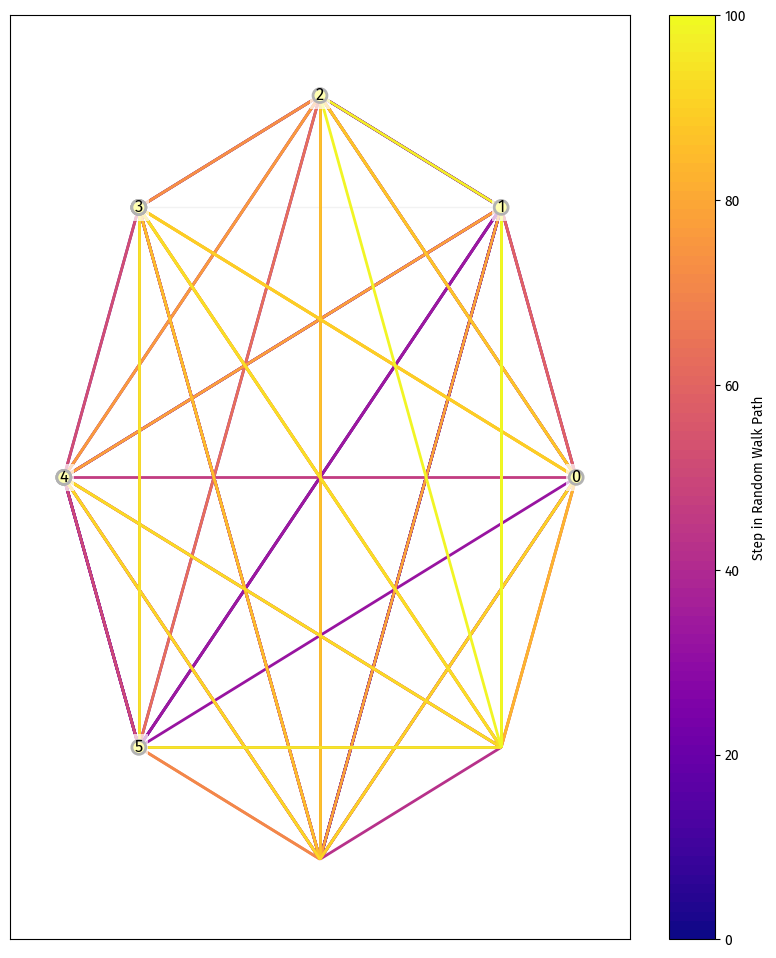

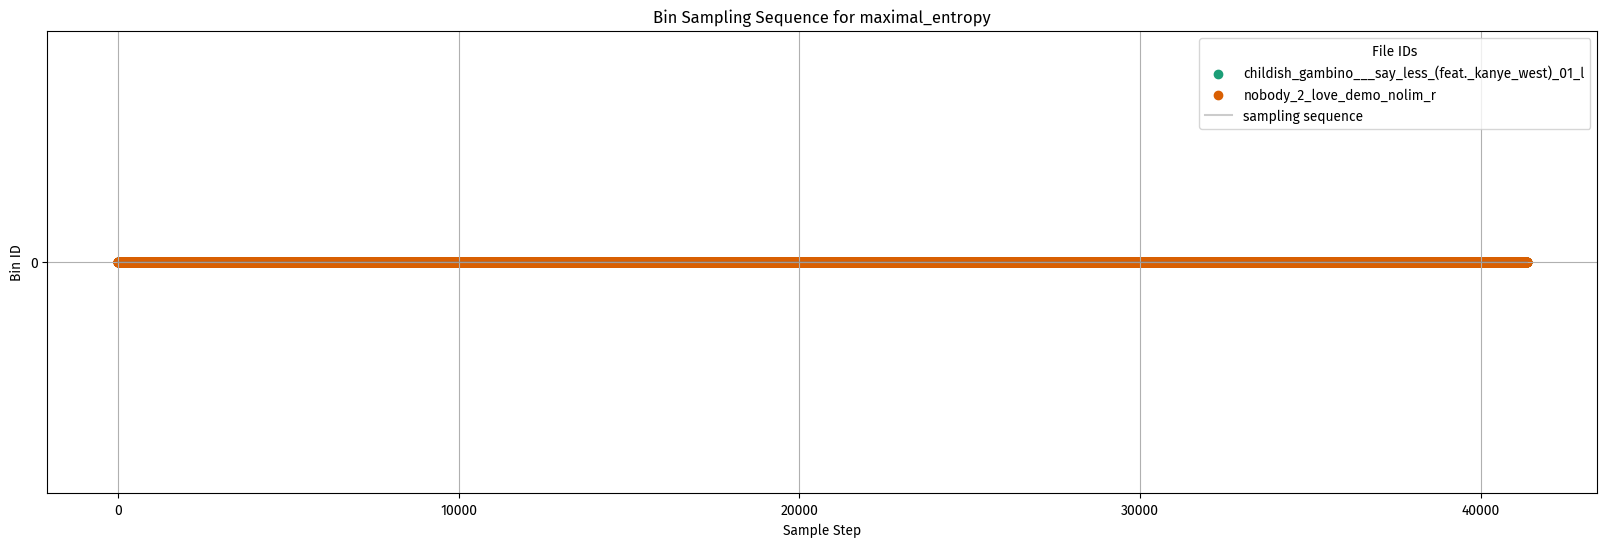

In [ ]:
### TEST EACH THING
from matplotlib.colors import to_rgba, get_cmap

### view the havoc you've wrought upon your poor ordered dataset
## note - visualization (exporting to video) can be very computationally expensive with a high # bins and random walk-type processes
def create_color_mapping(file_ids, cmap_name='tab10'):
    """
    Generates a color mapping for a list of file IDs using a matplotlib colormap.

    Args:
    file_ids (list): List of file IDs to map colors to.
    cmap_name (str): Name of the matplotlib colormap to use.

    Returns:
    dict: A dictionary mapping each file ID to a color.
    """
    color_cycle = plt.get_cmap(cmap_name).colors  # Get color cycle from colormap
    color_iterator = cycle(color_cycle)  # Create an iterator that cycles through the colors
    file_id_to_color = {file_id: next(color_iterator) for file_id in file_ids}
    return file_id_to_color

cmap = create_color_mapping(all_files, 'Dark2')

all_samples, timeseries, video, checkcrossfiles = sample_data(test_set, all_files, indices_color_mapping=cmap, cross_file_sampling=True, method="maximal_entropy", clip_bins=False, use_fallback=False)

In [ ]:

real_data_error = np.array(extract_data_arrays(all_samples, processing_type='original', component_type='real')) ## (83, 256, 100)
imaginary_data_error = np.array(extract_data_arrays(all_samples, processing_type='original', component_type='imaginary'))  ## (90, 256, 100)
real_data_train = np.array(extract_data_arrays(all_samples, processing_type='lossy', component_type='real')) ## (81, 256, 100)
imaginary_data_train = np.array(extract_data_arrays(all_samples, processing_type='lossy', component_type='imaginary')) ## (91, 256, 100)
np.shape(real_data_error)


(3446, 256, 200)

In [ ]:
### input params for model training & summarize
from tensorflow.keras.layers import Concatenate, Input
from tensorflow.keras.models import Model
center_frequencies_khz = convert_to_khz(center_frequencies)

real_data_error = np.array(extract_data_arrays(all_samples, processing_type='original', component_type='real')) ## (83, 256, 100)
imaginary_data_error = np.array(extract_data_arrays(all_samples, processing_type='original', component_type='imaginary'))  ## (90, 256, 100)
real_data_train = np.array(extract_data_arrays(all_samples, processing_type='lossy', component_type='real')) ## (81, 256, 100)
imaginary_data_train = np.array(extract_data_arrays(all_samples, processing_type='lossy', component_type='imaginary')) ## (91, 256, 100)
input_shape = (256, 100, 1)
latent_dim = 25
epochs = 10
optimizer = Adam()
batch_size = 40
train_data = tf.data.Dataset.from_tensor_slices((real_data_train, imaginary_data_train))
train_data = train_data.map(lambda real, imag: (real, imag)).batch(batch_size, drop_remainder=True)
val_data = tf.data.Dataset.from_tensor_slices((real_data_error, imaginary_data_error))
def process_data(real, imag):
    return real, imag
val_data = val_data.map(process_data).batch(batch_size, drop_remainder=True)
vae, encoder, decoder = build_vae(input_shape, latent_dim)
vae.compile(optimizer=optimizer, loss='mse')  # Example loss functions for each output
encoder.compile()
decoder.compile()
vae.summary()
encoder.summary()
decoder.summary()

base_model_path = '/content/Model'
stochastic_process_name = 'rossler'

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 VAE_input_real (InputLayer  [(None, 256, 100, 1)]        0         []                            
 )                                                                                                
                                                                                                  
 VAE_input_imag (InputLayer  [(None, 256, 100, 1)]        0         []                            
 )                                                                                                
                                                                                                  
 encoder (Functional)        [(None, 25),                 6573570   ['VAE_input_real[0][0]',      
                              (None, 25),                            'VAE_input_imag[0][0]']    

In [ ]:
### train the network up - if you dare
run_training_loop(vae, encoder, decoder, train_data, val_data, epochs, optimizer, base_model_path, stochastic_process_name)

Epoch 1
Total Loss: 0.0372031741
Total Loss: 0.0671950951
Total Loss: 0.0372073501
Total Loss: 0.0671911091
Epoch 1: Average Loss: 0.05219913274049759, Average Validation Loss: 0.05219922959804535
1/1 [==============================] - 0s 20ms/step


WARNING    /usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
 [py.warnings]
  saving_api.save_model(



New best validation loss: 0.05219922959804535. Saving model and configuration to /content/Model_rossler_epoch_1_val_loss_0.0522.h5.
Model and configuration saved to /content/Model_rossler_epoch_1_val_loss_0.0522.h5 and /content/Model_rossler_epoch_1_val_loss_0.0522.h5_config.json
Epoch 2
Total Loss: 0.0372103862
Total Loss: 0.0671819448
Total Loss: 0.0372022875
Total Loss: 0.0671952
Epoch 2: Average Loss: 0.05219616740942001, Average Validation Loss: 0.05219874531030655
1/1 [==============================] - 0s 20ms/step


WARNING    /usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
 [py.warnings]
  saving_api.save_model(



New best validation loss: 0.05219874531030655. Saving model and configuration to /content/Model_rossler_epoch_2_val_loss_0.0522.h5.
Model and configuration saved to /content/Model_rossler_epoch_2_val_loss_0.0522.h5 and /content/Model_rossler_epoch_2_val_loss_0.0522.h5_config.json
Epoch 3
Total Loss: 0.0372065455
Total Loss: 0.0671916157
Total Loss: 0.0371976979
Total Loss: 0.0671731383
Epoch 3: Average Loss: 0.05219908058643341, Average Validation Loss: 0.05218541622161865
1/1 [==============================] - 0s 19ms/step


WARNING    /usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
 [py.warnings]
  saving_api.save_model(



New best validation loss: 0.05218541622161865. Saving model and configuration to /content/Model_rossler_epoch_3_val_loss_0.0522.h5.
Model and configuration saved to /content/Model_rossler_epoch_3_val_loss_0.0522.h5 and /content/Model_rossler_epoch_3_val_loss_0.0522.h5_config.json
Epoch 4
Total Loss: 0.0371998623
Total Loss: 0.0671872646
Total Loss: 0.0371979922
Total Loss: 0.0671817213
Epoch 4: Average Loss: 0.05219356343150139, Average Validation Loss: 0.05218985676765442
1/1 [==============================] - 0s 20ms/step
Epoch 5
Total Loss: 0.0371908173
Total Loss: 0.0671913847
Total Loss: 0.0371962264
Total Loss: 0.0671836659
Epoch 5: Average Loss: 0.052191101014614105, Average Validation Loss: 0.05218994617462158
1/1 [==============================] - 0s 19ms/step
Epoch 6
Total Loss: 0.0371995531
Total Loss: 0.0671846271
Total Loss: 0.0371846743
Total Loss: 0.0671600103
Epoch 6: Average Loss: 0.052192091941833496, Average Validation Loss: 0.05217234045267105
1/1 [=================

WARNING    /usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
 [py.warnings]
  saving_api.save_model(



New best validation loss: 0.05217234045267105. Saving model and configuration to /content/Model_rossler_epoch_6_val_loss_0.0522.h5.
Model and configuration saved to /content/Model_rossler_epoch_6_val_loss_0.0522.h5 and /content/Model_rossler_epoch_6_val_loss_0.0522.h5_config.json
Epoch 7
Total Loss: 0.0372028649
Total Loss: 0.0671754479
Total Loss: 0.0371956117
Total Loss: 0.067172125
Epoch 7: Average Loss: 0.05218915641307831, Average Validation Loss: 0.05218386650085449
1/1 [==============================] - 0s 19ms/step
Epoch 8
Total Loss: 0.0372038186
Total Loss: 0.0671926662
Total Loss: 0.0371877775
Total Loss: 0.0671840683
Epoch 8: Average Loss: 0.05219824239611626, Average Validation Loss: 0.05218592286109924
1/1 [==============================] - 0s 19ms/step
Epoch 9
Total Loss: 0.0372102484
Total Loss: 0.0671684742
Total Loss: 0.0371945202
Total Loss: 0.067189239
Epoch 9: Average Loss: 0.052189361304044724, Average Validation Loss: 0.052191879600286484
1/1 [===================

(['/content/Model/1715314552.5127175_rossler_tSNE_epoch_1.png',
  '/content/Model/1715314552.5127175_rossler_tSNE_epoch_2.png',
  '/content/Model/1715314552.5127175_rossler_tSNE_epoch_3.png',
  '/content/Model/1715314552.5127175_rossler_tSNE_epoch_4.png',
  '/content/Model/1715314552.5127175_rossler_tSNE_epoch_5.png',
  '/content/Model/1715314552.5127175_rossler_tSNE_epoch_6.png',
  '/content/Model/1715314552.5127175_rossler_tSNE_epoch_7.png',
  '/content/Model/1715314552.5127175_rossler_tSNE_epoch_8.png',
  '/content/Model/1715314552.5127175_rossler_tSNE_epoch_9.png',
  '/content/Model/1715314552.5127175_rossler_tSNE_epoch_10.png'],
 ['/content/Model/1715314552.5127175_rossler_Spectrogram_epoch_1.png',
  '/content/Model/1715314552.5127175_rossler_Spectrogram_epoch_2.png',
  '/content/Model/1715314552.5127175_rossler_Spectrogram_epoch_3.png',
  '/content/Model/1715314552.5127175_rossler_Spectrogram_epoch_4.png',
  '/content/Model/1715314552.5127175_rossler_Spectrogram_epoch_5.png',
  '

In [ ]:
### Get a file to run predictions on
file2predict, filters = configure_epochs(["/content/drive/MyDrive/Passenger.mp3"], duration=10, fft_size=256, downloadfile=False, rectify=False, min_frequency=20, max_frequency=20000, num_frequency_bins=100, bw=None, with_lossy_backprop=False, UseDualMono=False)

Detected 2 channels.
Running command: ffmpeg -y -i /content/drive/MyDrive/Passenger.mp3 -map_channel 0.0.0 -acodec pcm_s16le -ar 44100 -ac 1 -t 10 /content/drive/MyDrive/Passenger_L.wav
now passing file: /content/drive/MyDrive/Passenger_L.wav through filterbank...


filters/s: 100%|██████████| 1723/1723 [00:00<00:00, 2773.90filters/s]
WARNING    <ipython-input-62-52070187e482>:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  total_length = sum(len(data) for data in named_arrays.values())
 [py.warnings]
  total_length = sum(len(data) for data in named_arrays.values())



Type of filter_outputs: <class 'dict'>
now performing discrete fourier transform series for key: passenger_l...
performing calculations on original version of the original file...


DFTs per second: 100%|██████████| 441088/441088 [00:41<00:00, 10537.29DFTs/s]


In [ ]:
### Now run a new lossy file through VAE if you so choose
predict_data_real = np.array(extract_data_arrays(file2predict, processing_type='original', component_type='real'))
predict_data_imaginary = np.array(extract_data_arrays(file2predict, processing_type='original', component_type='imaginary'))

# Pass the novel data through the VAE
outputs_real, outputs_imag = pass_novel_data_through_vae(vae, predict_data_real, predict_data_imaginary, batch_size=16)
plot_novel_spectrogram(outputs_real, outputs_imag, title="Generated Spectrogram from Novel Data")


# Concatenate all decoded data along the first dimension to form a complete dataset
all_decoded_data = np.concatenate(all_decoded_data, axis=0)
print("Complete Decoded Data Shape:", all_decoded_data.shape)  # This should now be (1723, 256, 100) if your total number of samples is 1723


InvalidArgumentError: Graph execution error:

Detected at node vae/encoder/conv2d/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-250-21aca47926f2>", line 325, in <cell line: 325>

  File "<ipython-input-250-21aca47926f2>", line 319, in pass_novel_data_through_vae

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2655, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/activations.py", line 306, in relu

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5395, in relu

input depth must be evenly divisible by filter depth: 1 vs 2
	 [[{{node vae/encoder/conv2d/Relu}}]] [Op:__inference_predict_function_20224]

In [ ]:
print(center_frequencies)
center_frequencies_khz = convert_to_khz(center_frequencies)
reconstructed_signal = reconstruct_signal_from_nn(all_decoded_data, center_frequencies_khz)
sf.write('/content/drive/MyDrive/test_922.wav', reconstructed_signal, 44100)

[ 0.02        0.03130364  0.04312078  0.05547472  0.06838986  0.0818917
  0.09600687  0.11076325  0.12618997  0.14231747  0.15917759  0.1768036
  0.19523031  0.21449408  0.23463294  0.25568663  0.27769673  0.30070668
  0.32476188  0.34990984  0.37620018  0.40368481  0.43241797  0.46245638
  0.49385933  0.52668881  0.56100963  0.59688953  0.63439933  0.67361308
  0.71460818  0.75746554  0.80226977  0.84910931  0.89807661  0.94926833
  1.00278552  1.05873382  1.11722366  1.17837049  1.24229503  1.30912344
  1.37898764  1.45202553  1.5283813   1.60820565  1.69165615  1.77889753
  1.87010199  1.96544957  2.06512846  2.16933544  2.27827619  2.39216575
  2.51122893  2.63570075  2.76582691  2.90186427  3.04408134  3.19275886
  3.34819031  3.51068248  3.68055613  3.85814656  4.04380434  4.23789592
  4.44080444  4.65293041  4.87469255  5.1065286   5.34889619  5.60227372
  5.86716135  6.14408193  6.43358208  6.73623326  7.05263286  7.38340544
  7.72920391  8.09071084  8.46863982  8.86373685  9.2

TypeError: 'module' object is not callable

In [ ]:
'''
#### Example call to to reload old models - not we don't run this in the workflow provided, but you can use this to skip training if need be ---
model_files = ['/content/model_maximal_entropy_epoch_15_val_loss_0.0248.h5', '/content/model_maximal_entropy_epoch_10_val_loss_0.0249.h5']
config_files = ['/content/model_maximal_entropy_epoch_15_val_loss_0.0248.h5_config.json', '/content/model_maximal_entropy_epoch_10_val_loss_0.0249.h5_config.json']

loaded_models = load_models_and_configs(model_files, config_files)
'''

# Experimental Procedure (Thesis Dataset)

note since seeding isn't implemented (and I'm not sure how we'd even achieve that in some of these cases save google letting us literally copy memory dumps), you cannot replicate my results EXACTLY, though you should be able to come pretty close.

# Graveyard of Old Functions

In [ ]:
def process_audio(audio_data, file_sr):
    filter_outputs = []
    try:
        # Using delete=True to ensure automatic cleanup
        with tempfile.NamedTemporaryFile(suffix='.wav', mode='w+b', delete=True) as temp_wav:
            sf.write(temp_wav.name, audio_data, file_sr)
            temp_wav.flush()
            os.fsync(temp_wav.fileno())

            # Assuming load and process can handle being passed the file path
            processed_data = load_and_process(temp_wav.name)
            # Do something with processed_data
            filter_outputs.append(processed_data)

    except Exception as e:
        print(f"Error during audio processing: {e}")

    return filter_outputs

def load_and_process(file_path):
    # Example function that loads and processes the audio data
    data, sr = sf.read(file_path)
    # Process data here...
    return data

# Example usage
audio_data = np.random.randn(44100)  # Example audio data array
file_sr = 44100  # Example sample rate
results = process_audio(audio_data, file_sr)


In [ ]:
# @title archiac functions (for reference, but you might adapt these)
def training_separate(filter_outputs, random_order=False):
    assert filter_outputs, "filter_outputs is empty or None"
    assert isinstance(filter_outputs[0], np.ndarray), "Items in filter_outputs should be np.ndarray"
    assert filter_outputs[0].ndim == 2, "Items in filter_outputs should be 2-dimensional"

    if random_order:
        np.random.shuffle(filter_outputs)

    num_frequency_bins = filter_outputs[0].shape[1]
    separated_bins = {f"frequencybin_{i}": [] for i in range(num_frequency_bins)}

    for frame in filter_outputs:
        assert frame.shape[1] == num_frequency_bins, f"Frame shape mismatch: {frame.shape[1]} vs {num_frequency_bins}"
        for i in range(num_frequency_bins):
            bin_data = frame[:, i]
            assert np.issubdtype(bin_data.dtype, np.number), f"Expected numeric data type, found {bin_data.dtype} in bin {i}"
            separated_bins[f"frequencybin_{i}"].append(bin_data)
            print(f"{separated_bins}")

    return separated_bins

def dft_forwholeset(named_arrays):
    print(f"We're now preparing your training set... || Now on file: {os.path.basename(file_path)} || Current step = discrete fourier transform")
    dft_meter = tqdm(total=np.sum(len(data) for _, data in named_arrays.items()), desc='DFTs per second', unit='DFTs', leave=True, position=0)
    for key, data in named_arrays.items():
        af_array = af.interop.from_ndarray(data)
        dft_result = af.dft(af_array)
        dfts_for_network[key] = dft_result.to_ndarray()
        dft_meter.update(1)
    dft_meter.close()
    return dfts_for_network


In [ ]:
#stable model w/imaginary tf backend/slice

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Conv1D, Conv1DTranspose, Conv2D, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
import numpy as np

def sampling(z_mean, z_log_var):
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

base_model_path = '/content/model'

def ensure_directory_exists(filepath):
    directory = os.path.dirname(filepath)
    if not os.path.exists(directory):
        os.makedirs(directory)

def generate_model_path(base_path, epoch, val_loss, stochastic_process_name):
    """Generates a file path for saving models with dynamic elements such as epoch number and validation loss."""
    # Format the validation loss to include in the filename (e.g., round to 4 decimal places)
    formatted_val_loss = f"{val_loss:.4f}"
    return f"{base_path}_{stochastic_process_name}_epoch_{epoch}_val_loss_{formatted_val_loss}.h5"

def save_model_and_config(model, filepath):
    ensure_directory_exists(filepath)  # Ensure the directory exists
    model.save(filepath, save_format='h5')  # Saving the model

    model_json = model.to_json()
    json_path = f"{filepath}_config.json"
    with open(json_path, 'w') as json_file:
        json_file.write(model_json)
    print(f"Model and configuration saved to {filepath} and {json_path}")


def build_encoder(input_shape, latent_dim):
    K.clear_session()  # Ensure a clean graph
    inputs = Input(shape=input_shape, name='encoder_input')
    x = Conv1D(32, 3, activation='relu', padding='same', strides=2)(inputs)
    x = Conv1D(64, 3, activation='relu', padding='same', strides=2)(x)
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    z = Lambda(lambda inputs: sampling(inputs[0], inputs[1]), output_shape=(latent_dim,))([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder

def build_decoder(latent_dim, shape_before_flattening):
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(np.prod(shape_before_flattening), activation='relu')(latent_inputs)
    x = Reshape(shape_before_flattening)(x)
    x = Conv2DTranspose(64, 3, activation='relu', padding='same', strides=(1, 2))(x)
    x = Conv2DTranspose(32, 3, activation='relu', padding='same', strides=(1, 2))(x)
    x = Conv2DTranspose(2, 3, activation='sigmoid', padding='same')(x)
    decoder = Model(latent_inputs, x, name='decoder')
    return decoder

def build_vae(input_shape, latent_dim):
    encoder = build_encoder(input_shape, latent_dim)
    shape_before_flattening = (256, 25, 64)  # Example shape, adjust as necessary
    decoder = build_decoder(latent_dim, shape_before_flattening)
    inputs = Input(shape=input_shape, name='VAE_input')
    z_mean, z_log_var, z = encoder(inputs)
    outputs = decoder(z)
    vae = Model(inputs, [outputs, z_mean, z_log_var], name='vae')
    vae.encoder = encoder
    vae.decoder = decoder
    return vae, encoder, decoder

def validate_model(model, x_val):
    outputs, z_mean, z_log_var = model(x_val, training=False)
    loss = compute_vae_loss(x_val, outputs, z_mean, z_log_var)
    return loss

def compute_vae_loss(inputs, outputs, z_mean, z_log_var):
    tf.print("Input type:", inputs.dtype, "Output type:", outputs.dtype)
    inputs = tf.cast(inputs, tf.float32)
    outputs = tf.cast(outputs, tf.float32)
    tf.print("Input shape:", tf.shape(inputs))
    tf.print("Output shape:", tf.shape(outputs))
    tf.print("z_mean shape:", tf.shape(z_mean))
    tf.print("z_log_var shape:", tf.shape(z_log_var))
    if inputs.shape != outputs.shape:
        tf.print("Shape mismatch between inputs and outputs!")
        outputs = tf.reshape(outputs, tf.shape(inputs))
    reconstruction_loss = tf.reduce_mean(tf.square(inputs - outputs), axis=[1, 2, 3])
    tf.print("Reconstruction loss:", reconstruction_loss)
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    tf.print("KL loss:", kl_loss)
    total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)  # Ensure reduction over the batch
    tf.print("Total loss:", total_loss)
    return total_loss

def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        outputs, z_mean, z_log_var = model(x, training=True)
        loss = compute_vae_loss(x, outputs, z_mean, z_log_var)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

@tf.function
def train_model(model, train_dataset, val_dataset, optimizer):
    total_loss = 0.0
    num_batches = 0
    for x_batch in train_dataset:
        loss = train_step(model, x_batch, optimizer)
        total_loss += loss
        num_batches += 1
    avg_loss = total_loss / tf.cast(num_batches, tf.float32)

    total_val_loss = 0.0
    num_val_batches = 0
    for x_val in val_dataset:
        val_loss = validate_model(model, x_val)
        total_val_loss += val_loss
        num_val_batches += 1
    avg_val_loss = total_val_loss / tf.cast(num_val_batches, tf.float32)

    return avg_loss, avg_val_loss

def run_training_loop(model, train_data, val_data, epochs, optimizer, base_model_path, stochastic_process_name, autosavenetwork=True):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}")
        avg_loss, avg_val_loss = train_model(model, train_data, val_data, optimizer)
        avg_val_loss = avg_val_loss.numpy()  # Ensure this is a numpy value for comparisons
        print(f"Epoch {epoch+1}: Average Loss: {avg_loss.numpy()}, Average Validation Loss: {avg_val_loss}")
        current_model_path = generate_model_path(base_model_path, epoch + 1, avg_val_loss, stochastic_process_name)
        if autosavenetwork:
          if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            current_model_path = generate_model_path(base_model_path, epoch + 1, avg_val_loss, stochastic_process_name)
            print(f"New best validation loss: {best_val_loss}. Saving model and configuration to {current_model_path}.")
            save_model_and_config(model, current_model_path)  # This call should save both the model and JSON
        print("complete.")

#input_shape = (256, 100, 2)
#latent_dim = 10
#epochs = 16
#optimizer = Adam()
#batch_size = 17
#train_data = tf.data.Dataset.from_tensor_slices((real_data_train, imaginary_data_train))
#train_data = train_data.map(lambda real, imag: tf.stack([real, imag], axis=-1)).batch(batch_size)
#val_data = tf.data.Dataset.from_tensor_slices((real_data_error, imaginary_data_error))
#val_data = val_data.map(lambda real, imag: tf.stack([real, imag], axis=-1)).batch(batch_size)
#vae, encoder, decoder = build_vae(input_shape, latent_dim)
#vae.compile()
#encoder.compile()
#decoder.compile()
#run_training_loop(vae, train_data, val_data, epochs, optimizer, base_model_path, sampling_method)

In [ ]:
# STABLE
def sample_data(epoch_data, file_ids, cross_file_sampling=False, method='ornstein-uhlenbeck', sample_size=100, **params):
    if cross_file_sampling:
        sampled_data = {'total_list': {'original': {'real': {}, 'imaginary': {}},
                                       'lossy': {'real': {}, 'imaginary': {}}}}
    else:
        sampled_data = {file_id: {'original': {'real': {}, 'imaginary': {}},
                                  'lossy': {'real': {}, 'imaginary': {}}}
                        for file_id in file_ids}

    all_bins = {}
    for file_id in file_ids:
        print(file_id)
        if file_id not in epoch_data:
            pprint.saferepr(epoch_data)
            raise ValueError(f"No data found for file_id '{file_id}'.")
        for processing_type in ['original', 'lossy']:
            for component_type in ['real', 'imaginary']:
                key = (file_id, processing_type, component_type)
                if key not in all_bins:
                    all_bins[key] = []
                all_bins[key].extend(epoch_data[file_id][processing_type][component_type].keys())

    unique_bins_list = list(set.union(*(set(bins) for bins in all_bins.values()))) if cross_file_sampling else list(set.intersection(*(set(bins) for bins in all_bins.values())))
    print(unique_bins_list)
    num_samples_default = min(sample_size, len(unique_bins_list))
    bin_min, bin_max = 0, len(unique_bins_list) - 1

    indices, sampleset_timeseries, html_video = stochastic_process(method, unique_bins_list, num_samples_default, bin_min, bin_max, **params)

    for file_id in file_ids:
        for processing_type in ['original', 'lossy']:
            for component_type in ['real', 'imaginary']:
                target = sampled_data['total_list'][processing_type][component_type] if cross_file_sampling else sampled_data[file_id][processing_type][component_type]
                target.clear()
                data_keys = list(epoch_data[file_id][processing_type][component_type].keys())

                for idx in indices:
                    if idx < len(data_keys):
                        bin_key = data_keys[idx]
                        data = epoch_data[file_id][processing_type][component_type][bin_key]
                        target[bin_key] = data

    return sampled_data, sampleset_timeseries, html_video

In [ ]:
# STABLE
# playing with time ---> stochastic process definitions

def simple_random_shuffle(bins):
    """Shuffles bins randomly."""
    np.random.shuffle(bins)
    return bins

def initialize_graph(num_bins):
    """Create a linear chain graph with num_bins nodes."""
    G = nx.Graph()
    for i in range(num_bins):
        G.add_node(i)
        if i > 0:
            G.add_edge(i, i - 1)
    return G

def calculate_transition_probabilities(G):
    """Calculates transition probabilities for a maximal entropy random walk."""
    L = nx.laplacian_matrix(G).todense()  # laplacian matrix of the graph
    evals, evecs = np.linalg.eigh(L)  # eigenvalues and eigenvectors
    pi = evecs[:, 0] ** 2  # stationary distribution
    pi_matrix = np.diagflat(pi)
    P = pi_matrix @ evecs @ np.linalg.inv(pi_matrix @ np.diagflat(evecs[:, 0]))
    return P

def maximal_entropy_random_walk(num_bins, num_samples, start=None):
    """Performs a maximal entropy random walk on a graph with nodes num_bins."""
    G = initialize_graph(num_bins)
    if start is None:
        start = np.random.choice(list(G.nodes()))
    P = calculate_transition_probabilities(G)
    path = [start]
    for _ in range(1, num_samples):
        current = path[-1]
        probabilities = P[current, :].flatten()
        probabilities = np.clip(probabilities, 0, None)
        probabilities /= probabilities.sum()
        next_node = np.random.choice(list(G.nodes()), p=probabilities)
        path.append(next_node)
    return path

def animate_random_walk(params, num_bins):
    num_samples = params.get('num_samples', 100)
    path = maximal_entropy_random_walk(num_bins, num_samples)
    G = initialize_graph(num_bins)
    pos = nx.shell_layout(G)
    fig, ax = plt.subplots()
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.4)
    nodes = nx.draw_networkx_nodes(G, pos, ax=ax, node_color='grey', alpha=0.8, node_size=15)
    labels = nx.draw_networkx_labels(G, pos, ax=ax, font_size = 2)

    color_map = matplotlib.colormaps['plasma']

    def update(num):
        node_colors = [1 if n == path[num] else 0 for n in G.nodes()]
        nodes.set_array(node_colors)
        nodes.set_cmap(color_map)
        return nodes,

    ani = FuncAnimation(fig, update, frames=len(path), repeat=False)
    return ani, path

def ornstein_uhlenbeck(start, num_samples, mean, scale, theta, dt=1):
    """Generate an Ornstein-Uhlenbeck process path from a starting point."""
    if num_samples <= 0:
        raise ValueError("num_samples must be a positive integer")
    path = np.zeros(num_samples)
    path[0] = start
    for i in range(1, num_samples):
        drift = theta * (mean - path[i-1]) * dt
        randomness = scale * np.random.normal()
        path[i] = path[i-1] + drift + randomness
    return path

def animate_ornstein_uhlenbeck(ou_path, num_samples):
    """Animate the Ornstein-Uhlenbeck process using a given path."""
    fig, ax = plt.subplots()
    line, = ax.plot(ou_path, 'r-', label='OU Process')
    point, = ax.plot([], [], 'ro')

    ax.set_xlim(0, num_samples - 1)
    ax.set_ylim(min(ou_path), max(ou_path))
    ax.legend()

    def init():
        point.set_data([], [])
        return line, point,

    def animate(i):
        point.set_data(i, ou_path[i])
        return line, point,

    ani = FuncAnimation(fig, animate, init_func=init, frames=num_samples, interval=50, blit=True)
    return ani

def estimate_parameter_bounds(process_func, num_trials, **params):
    results = []
    for _ in range(num_trials):
        results.append(process_func(**params))
    results = np.array(results)
    min_vals = results.min(axis=0)
    max_vals = results.max(axis=0)
    return min_vals, max_vals

def scale_parameter(norm_value, min_val, max_val):
    return norm_value * (max_val - min_val) + min_val

def rossler_attractor(start, num_samples, a, b, c, dt=0.01):
    x, y, z = start
    path_x = [x]
    path_y = [y]
    path_z = [z]
    for _ in range(num_samples - 1):
        dx = -y - z
        dy = x + a * y
        dz = b + z * (x - c)
        x += dx * dt
        y += dy * dt
        z += dz * dt
        path_x.append(x)
        path_y.append(y)
        path_z.append(z)
    return np.array([path_x, path_y, path_z]).T

def animate_rossler(process_path):
    """Animate the Rössler attractor."""
    %matplotlib inline
    x, y, z = process_path.T
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    line_z, = ax.plot([], [], [], lw=2, label='Z-component', color='red')
    line_x, = ax.plot([], [], [], lw=1, label='X-component', color='blue', alpha=0.5)
    line_y, = ax.plot([], [], [], lw=1, label='Y-component', color='green', alpha=0.5)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', borderaxespad=0.7, shadow=True)
    text = ax.text2D(0.05, 0.95, "X, Y, and Z Components of the Rössler system", transform=ax.transAxes, fontsize='small')

    def init():
        ax.set_xlim([min(x), max(x)])
        ax.set_ylim([min(y), max(y)])
        ax.set_zlim([min(z), max(z)])
        ax.set_xlabel('X-axis', fontsize='x-small')
        ax.set_ylabel('Y-axis', fontsize='x-small')
        ax.set_zlabel('Z-axis', fontsize='x-small')
        return line_z, line_x, line_y, text

    def animate(i):
        line_z.set_data(x[:i], y[:i])
        line_z.set_3d_properties(z[:i])
        line_x.set_data(x[:i], [0]*i)
        line_x.set_3d_properties(z[:i])
        line_y.set_data([0]*i, y[:i])
        line_y.set_3d_properties(z[:i])
        ax.view_init(elev=10, azim=i * 60 / len(x))
        return line_z, line_x, line_y, text
    rosslerspace = FuncAnimation(fig, animate, init_func=init, frames=len(x), interval=50, blit=True)
    html_video = HTML(rosslerspace.to_html5_video())
    display(html_video)

    return html_video

def plot_indices(indices, total_bins, method_name):
    """Plot the indices as a time series to visualize the selection sequence."""
    label_step = max(1, total_bins // 30)
    label_size = min(10, max(5, 500 // total_bins))
    plt.figure(figsize=(12, 6))
    plt.plot(indices, 'o-', label=f'Indices from {method_name}')
    bin_labels = [str(i) if i % label_step == 0 else '' for i in range(total_bins)]

    plt.yticks(np.arange(0, total_bins, label_step), bin_labels[::label_step], fontsize=label_size)
    plt.xlabel('Sample Step')
    plt.ylabel('Bin ID')
    plt.title(f'Bin Sampling Sequence for {method_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

def stochastic_process(method, unique_bins_list, sample_size, bin_min, bin_max, **params):
    if method == 'simple_random_shuffle':
        np.random.shuffle(unique_bins_list)
        indices = np.arange(len(unique_bins_list))
        sampleset_timeseries = plot_indices(indices, len(unique_bins_list), method)
        html_video = None
        return indices, sampleset_timeseries, html_video

    if method == 'ornstein-uhlenbeck':
        ou_params = {
            'start': 0,
            'num_samples': sample_size,
            'mean': 0.5 * (bin_min + bin_max),
            'scale': 1,
            'theta': 0.1,
            'dt': 1
        }
        ou_params.update(params)
        _, max_path = estimate_parameter_bounds(ornstein_uhlenbeck, sample_size, **ou_params)
        ou_params['mean'] = scale_parameter(params.get('mean_norm', 0.5), bin_min, bin_max)
        ou_params['scale'] = scale_parameter(params.get('scale_norm', 0.5), 0, max_path.std())
        ou_params['theta'] = scale_parameter(params.get('theta_norm', 0.5), 0.1, 1.0)
        process_path = ornstein_uhlenbeck(**ou_params)
        indices = np.clip(process_path, bin_min, bin_max).astype(int)
        sampleset_timeseries = plot_indices(indices, len(unique_bins_list), method)
        html_video = None
        if params.get('visualize', True):
            viz = animate_ornstein_uhlenbeck(process_path, sample_size)
            html_video = HTML(viz.to_html5_video())
            display(html_video)
        return indices, sampleset_timeseries, html_video

    if method == 'rossler':
        r_params = {
            'start': (bin_min, 0, 0),
            'num_samples': sample_size,
            'a': 0.2,
            'b': 0.2,
            'c': 5.7,
            'dt': 0.01
        }
        r_params.update(params)
        _, max_path = estimate_parameter_bounds(rossler_attractor, sample_size, **r_params)
        r_params['a'] = scale_parameter(params.get('a_norm', 0.2), 5, 12)
        r_params['b'] = scale_parameter(params.get('b_norm', 0.9), 43, 42)
        r_params['c'] = scale_parameter(params.get('c_norm', 0.5), 6, max_path[:, 2].max())
        process_path = rossler_attractor(**r_params)
        z_component = process_path[:, 2]
        normalized_indices = (z_component - np.min(z_component)) / (np.max(z_component) - np.min(z_component))
        indices = np.array(np.clip(normalized_indices * (bin_max - bin_min) + bin_min, bin_min, bin_max).astype(int))
        sampleset_timeseries = plot_indices(indices, len(unique_bins_list), method)
        html_video = None
        if params.get('visualize', True):
            viz = animate_rossler(process_path)
        return indices, sampleset_timeseries, html_video

    if method == 'maximal_entropy':
        indices = maximal_entropy_random_walk(len(unique_bins_list), len(unique_bins_list))
        sampleset_timeseries = plot_indices(indices, len(unique_bins_list), method)
        html_video = None
        if params.get('visualize', True):
            viz, process_path = animate_random_walk(params, len(unique_bins_list))
            html_video = HTML(viz.to_html5_video())
            display(html_video)
        return indices, sampleset_timeseries, html_video

    return indices, sampleset_timeseries, html_video